In [72]:
#%matplotlib notebook
import os
import sys
sys.path.append("numpy_path")
import numpy as np
import struct
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import keras.callbacks as cb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import cos, sin, pi
import math
from statistics import mean
import os.path

shape_size = 48

# define loss history
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

#plot losses
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

def feature_scaling(X):
    X = X.T
    for i in range(7):
        mean = X[i].mean()
        std = X[i].std()
        X[i] = [(x - mean)/std for x in X[i]]
    return X.T

In [27]:
data_size = 0
dummy1 = [0]*200
dummy2 = [0]*6
SP = np.array(np.reshape(dummy1, (1, 200)))
SH = np.array(np.reshape(dummy2, (1, 6)))
for i in range(2, 65):
    path = 'meep_code/data/DATA'+str(i)
    if not os.path.exists(path):
        #miss.append(i)
        print('Missing batch:' + str(i))
        continue
        
    files = next(os.walk(path))[2] #dir is your directory path as string]
    num_data = len(files)
    data_size += num_data
    skip = []
    
    coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
    xc, yc = coordinates[:, 0], coordinates[:, 1]
    xc = np.reshape(xc, (num_data, shape_size))
    yc = np.reshape(yc, (num_data, shape_size))
    
    for j in range(num_data):
        tmp = np.genfromtxt(path+'/'+'DATA'+str(i)+'_sp'+str(j)+'.txt')
        valid = True
        for q in range(200):
            if math.isnan(float(tmp[q])):
                print('Batch '+str(i)+'\tsample '+str(j)+' has NAN value')
                valid = False
                break
            if tmp[q] > 3:
                print('Batch '+str(i)+'\tsample '+str(j)+' has extreme value')
                valid = False
                break
        if not valid:
            #skip.append(j)
            continue
        SP = np.concatenate((SP, np.reshape(tmp, (1, 200))))
        tmp = []
        for q in range(6):
            tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
        SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
    print('Batch '+str(i)+' has \t'+str(num_data)) 

Batch 2 has 	7
Batch 3 has 	6
Batch 4 has 	17
Batch 5 has 	5
Batch 6 has 	14
Batch 7 has 	14
Batch 8 has 	40
Batch 9 has 	5
Batch 10 has 	14
Batch 11 has 	14
Batch 12 has 	40
Batch 13 has 	13
Batch 14 has 	37
Batch 15 has 	37
Batch 16 has 	106
Batch 17 has 	5
Batch 18 has 	14
Batch 19 has 	14
Batch 20 has 	40
Batch 21 has 	13
Batch 22 has 	37
Batch 23 has 	37
Batch 24 has 	106
Batch 25 has 	13
Batch 26 has 	37
Batch 27 has 	37
Batch 28 has 	106
Batch 29 has 	35
Batch 30 has 	100
Batch 31 has 	100
Batch 32 has 	287
Batch 33 has 	5
Batch 34 has 	14
Batch 35 has 	14
Batch 36 has 	40
Batch 37 has 	13
Batch 38 has 	37
Batch 39 has 	37
Batch 40 has 	106
Batch 41 has 	13
Batch 42 has 	37
Batch 43 has 	37
Batch 44 has 	106
Batch 45 has 	35
Batch 46 has 	100
Batch 47 has 	100
Batch 48 has 	287
Batch 49 has 	13
Batch 50 has 	37
Batch 51 has 	37
Batch 52 has 	106
Batch 53 has 	35
Batch 54 has 	100
Batch 55 has 	100
Batch 56 has 	287
Batch 57 has 	35
Batch 58 has 	100
Batch 59 has 	100
Batch 60 ha

In [28]:
print('Total # of data: ' + str(len(SP)))
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
SP_F, SH_F = np.reshape(SP[1], (1, 200)),np.reshape(SH[1], (1, 6))
for i in range(2, len(SP)):
    peak = 0
    for j in range(1, 200):
        if SP[i][j - 1] >= 0.6 >=SP[i][j]:
            peak += 1
    if peak == 1:
        SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
        SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))

Total # of data: 4989


In [29]:
DATA = np.append(SP_F, SH_F, axis = 1)
np.random.shuffle(DATA)

Y = DATA[:, :200]
X = DATA[:,200:]

train_size = int(len(DATA) * 0.8)

train_X = X[0:train_size, :]
train_Y = Y[0:train_size, :]
test_X = X[train_size:, :]
test_Y = Y[train_size:, :]

In [30]:
in_dim = 6
out_dim = 200
simulator = Sequential()
simulator.add(Dense(20, activation='relu', input_dim=in_dim))
simulator.add(Dropout(0.2))
simulator.add(Dense(500, activation='relu'))
simulator.add(Dropout(0.5))
simulator.add(Dense(500, activation='relu'))
simulator.add(Dropout(0.5))
# simulator.add(Dense(200, activation='relu'))
# simulator.add(Dropout(0.5))
simulator.add(Dense(200, activation='relu'))
simulator.add(Dropout(0.5))
simulator.add(Dense(200, activation='relu'))
simulator.add(Dropout(0.2))
simulator.add(Dense(out_dim, activation='sigmoid'))
simulator.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.Adam(lr = 0.001))

In [46]:
simulator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 20)                140       
_________________________________________________________________
dropout_21 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 500)               10500     
_________________________________________________________________
dropout_22 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_23 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 200)               100200    
__________

C:\Users\jeffe\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 372 samples, validate on 93 samples
Epoch 1/1000
 - 1s - loss: 0.1569 - val_loss: 0.0293
Epoch 2/1000
 - 0s - loss: 0.0328 - val_loss: 0.0326
Epoch 3/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 4/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 5/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 6/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 7/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 8/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 9/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 10/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 11/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 12/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 13/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 14/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 15/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 16/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 17/1000
 - 0s - loss: 0.0331 - val_loss: 0.0326
Epoch 18/1000
 - 0s - loss: 0.0331 - val_loss:

 - 0s - loss: 0.0148 - val_loss: 0.0129
Epoch 152/1000
 - 0s - loss: 0.0138 - val_loss: 0.0123
Epoch 153/1000
 - 0s - loss: 0.0148 - val_loss: 0.0129
Epoch 154/1000
 - 0s - loss: 0.0139 - val_loss: 0.0130
Epoch 155/1000
 - 0s - loss: 0.0149 - val_loss: 0.0121
Epoch 156/1000
 - 0s - loss: 0.0147 - val_loss: 0.0127
Epoch 157/1000
 - 0s - loss: 0.0146 - val_loss: 0.0116
Epoch 158/1000
 - 0s - loss: 0.0144 - val_loss: 0.0118
Epoch 159/1000
 - 0s - loss: 0.0140 - val_loss: 0.0120
Epoch 160/1000
 - 0s - loss: 0.0143 - val_loss: 0.0117
Epoch 161/1000
 - 0s - loss: 0.0140 - val_loss: 0.0118
Epoch 162/1000
 - 0s - loss: 0.0144 - val_loss: 0.0125
Epoch 163/1000
 - 0s - loss: 0.0142 - val_loss: 0.0122
Epoch 164/1000
 - 0s - loss: 0.0138 - val_loss: 0.0116
Epoch 165/1000
 - 0s - loss: 0.0142 - val_loss: 0.0123
Epoch 166/1000
 - 0s - loss: 0.0142 - val_loss: 0.0126
Epoch 167/1000
 - 0s - loss: 0.0132 - val_loss: 0.0123
Epoch 168/1000
 - 0s - loss: 0.0136 - val_loss: 0.0117
Epoch 169/1000
 - 0s - lo

 - 0s - loss: 0.0105 - val_loss: 0.0108
Epoch 301/1000
 - 0s - loss: 0.0114 - val_loss: 0.0106
Epoch 302/1000
 - 0s - loss: 0.0110 - val_loss: 0.0116
Epoch 303/1000
 - 0s - loss: 0.0114 - val_loss: 0.0120
Epoch 304/1000
 - 0s - loss: 0.0114 - val_loss: 0.0121
Epoch 305/1000
 - 0s - loss: 0.0107 - val_loss: 0.0102
Epoch 306/1000
 - 0s - loss: 0.0114 - val_loss: 0.0099
Epoch 307/1000
 - 0s - loss: 0.0112 - val_loss: 0.0102
Epoch 308/1000
 - 0s - loss: 0.0109 - val_loss: 0.0101
Epoch 309/1000
 - 0s - loss: 0.0111 - val_loss: 0.0105
Epoch 310/1000
 - 0s - loss: 0.0109 - val_loss: 0.0102
Epoch 311/1000
 - 0s - loss: 0.0114 - val_loss: 0.0101
Epoch 312/1000
 - 0s - loss: 0.0112 - val_loss: 0.0108
Epoch 313/1000
 - 0s - loss: 0.0106 - val_loss: 0.0118
Epoch 314/1000
 - 0s - loss: 0.0108 - val_loss: 0.0108
Epoch 315/1000
 - 0s - loss: 0.0104 - val_loss: 0.0102
Epoch 316/1000
 - 0s - loss: 0.0103 - val_loss: 0.0110
Epoch 317/1000
 - 0s - loss: 0.0106 - val_loss: 0.0097
Epoch 318/1000
 - 0s - lo

 - 0s - loss: 0.0097 - val_loss: 0.0105
Epoch 450/1000
 - 0s - loss: 0.0099 - val_loss: 0.0095
Epoch 451/1000
 - 0s - loss: 0.0094 - val_loss: 0.0117
Epoch 452/1000
 - 0s - loss: 0.0096 - val_loss: 0.0114
Epoch 453/1000
 - 0s - loss: 0.0096 - val_loss: 0.0103
Epoch 454/1000
 - 0s - loss: 0.0092 - val_loss: 0.0112
Epoch 455/1000
 - 0s - loss: 0.0093 - val_loss: 0.0113
Epoch 456/1000
 - 0s - loss: 0.0101 - val_loss: 0.0104
Epoch 457/1000
 - 0s - loss: 0.0094 - val_loss: 0.0111
Epoch 458/1000
 - 0s - loss: 0.0097 - val_loss: 0.0096
Epoch 459/1000
 - 0s - loss: 0.0099 - val_loss: 0.0097
Epoch 460/1000
 - 0s - loss: 0.0099 - val_loss: 0.0095
Epoch 461/1000
 - 0s - loss: 0.0095 - val_loss: 0.0105
Epoch 462/1000
 - 0s - loss: 0.0097 - val_loss: 0.0107
Epoch 463/1000
 - 0s - loss: 0.0091 - val_loss: 0.0102
Epoch 464/1000
 - 0s - loss: 0.0091 - val_loss: 0.0107
Epoch 465/1000
 - 0s - loss: 0.0100 - val_loss: 0.0109
Epoch 466/1000
 - 0s - loss: 0.0092 - val_loss: 0.0106
Epoch 467/1000
 - 0s - lo

 - 0s - loss: 0.0090 - val_loss: 0.0119
Epoch 599/1000
 - 0s - loss: 0.0091 - val_loss: 0.0098
Epoch 600/1000
 - 0s - loss: 0.0089 - val_loss: 0.0107
Epoch 601/1000
 - 0s - loss: 0.0089 - val_loss: 0.0112
Epoch 602/1000
 - 0s - loss: 0.0086 - val_loss: 0.0099
Epoch 603/1000
 - 0s - loss: 0.0092 - val_loss: 0.0122
Epoch 604/1000
 - 0s - loss: 0.0092 - val_loss: 0.0118
Epoch 605/1000
 - 0s - loss: 0.0089 - val_loss: 0.0123
Epoch 606/1000
 - 0s - loss: 0.0085 - val_loss: 0.0107
Epoch 607/1000
 - 0s - loss: 0.0086 - val_loss: 0.0103
Epoch 608/1000
 - 0s - loss: 0.0089 - val_loss: 0.0109
Epoch 609/1000
 - 0s - loss: 0.0093 - val_loss: 0.0126
Epoch 610/1000
 - 0s - loss: 0.0093 - val_loss: 0.0106
Epoch 611/1000
 - 0s - loss: 0.0092 - val_loss: 0.0102
Epoch 612/1000
 - 0s - loss: 0.0086 - val_loss: 0.0095
Epoch 613/1000
 - 0s - loss: 0.0089 - val_loss: 0.0095
Epoch 614/1000
 - 0s - loss: 0.0086 - val_loss: 0.0109
Epoch 615/1000
 - 0s - loss: 0.0086 - val_loss: 0.0104
Epoch 616/1000
 - 0s - lo

 - 0s - loss: 0.0088 - val_loss: 0.0102
Epoch 748/1000
 - 0s - loss: 0.0083 - val_loss: 0.0112
Epoch 749/1000
 - 0s - loss: 0.0079 - val_loss: 0.0129
Epoch 750/1000
 - 0s - loss: 0.0084 - val_loss: 0.0130
Epoch 751/1000
 - 0s - loss: 0.0083 - val_loss: 0.0134
Epoch 752/1000
 - 0s - loss: 0.0081 - val_loss: 0.0116
Epoch 753/1000
 - 0s - loss: 0.0083 - val_loss: 0.0113
Epoch 754/1000
 - 0s - loss: 0.0088 - val_loss: 0.0116
Epoch 755/1000
 - 0s - loss: 0.0079 - val_loss: 0.0129
Epoch 756/1000
 - 0s - loss: 0.0081 - val_loss: 0.0096
Epoch 757/1000
 - 0s - loss: 0.0083 - val_loss: 0.0105
Epoch 758/1000
 - 0s - loss: 0.0082 - val_loss: 0.0108
Epoch 759/1000
 - 0s - loss: 0.0085 - val_loss: 0.0116
Epoch 760/1000
 - 0s - loss: 0.0083 - val_loss: 0.0106
Epoch 761/1000
 - 0s - loss: 0.0080 - val_loss: 0.0116
Epoch 762/1000
 - 0s - loss: 0.0078 - val_loss: 0.0102
Epoch 763/1000
 - 0s - loss: 0.0082 - val_loss: 0.0112
Epoch 764/1000
 - 0s - loss: 0.0083 - val_loss: 0.0105
Epoch 765/1000
 - 0s - lo

 - 0s - loss: 0.0077 - val_loss: 0.0132
Epoch 897/1000
 - 0s - loss: 0.0078 - val_loss: 0.0115
Epoch 898/1000
 - 0s - loss: 0.0078 - val_loss: 0.0127
Epoch 899/1000
 - 0s - loss: 0.0076 - val_loss: 0.0130
Epoch 900/1000
 - 0s - loss: 0.0077 - val_loss: 0.0137
Epoch 901/1000
 - 0s - loss: 0.0084 - val_loss: 0.0142
Epoch 902/1000
 - 0s - loss: 0.0074 - val_loss: 0.0155
Epoch 903/1000
 - 0s - loss: 0.0075 - val_loss: 0.0133
Epoch 904/1000
 - 0s - loss: 0.0080 - val_loss: 0.0138
Epoch 905/1000
 - 0s - loss: 0.0078 - val_loss: 0.0126
Epoch 906/1000
 - 0s - loss: 0.0077 - val_loss: 0.0124
Epoch 907/1000
 - 0s - loss: 0.0080 - val_loss: 0.0134
Epoch 908/1000
 - 0s - loss: 0.0073 - val_loss: 0.0114
Epoch 909/1000
 - 0s - loss: 0.0085 - val_loss: 0.0130
Epoch 910/1000
 - 0s - loss: 0.0074 - val_loss: 0.0130
Epoch 911/1000
 - 0s - loss: 0.0078 - val_loss: 0.0114
Epoch 912/1000
 - 0s - loss: 0.0087 - val_loss: 0.0108
Epoch 913/1000
 - 0s - loss: 0.0080 - val_loss: 0.0128
Epoch 914/1000
 - 0s - lo

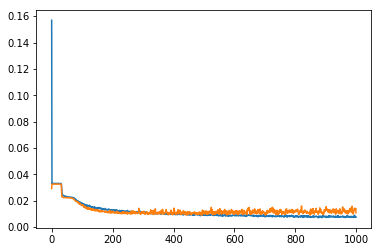

In [31]:
history = simulator.fit(train_X, train_Y, 
                    epochs=1000, 
                    batch_size=20,
                    validation_data=(test_X, test_Y), 
                    verbose=2)

train_score = simulator.evaluate(train_X, train_Y, batch_size=20)
test_score = simulator.evaluate(test_X, test_Y, batch_size= 50)
print(train_score)
print(test_score)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

Test 0
True spectrum: 


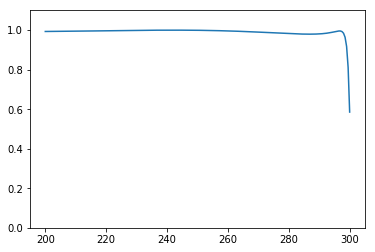

Predicted spectrum: 


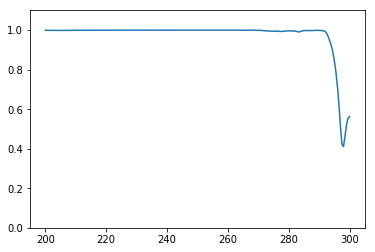

Test 1
True spectrum: 


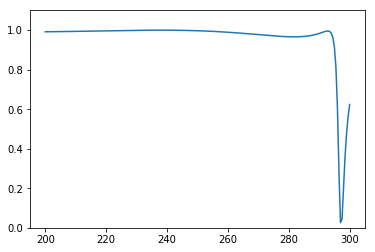

Predicted spectrum: 


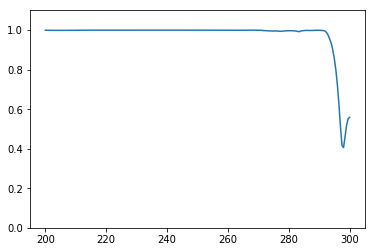

Test 2
True spectrum: 


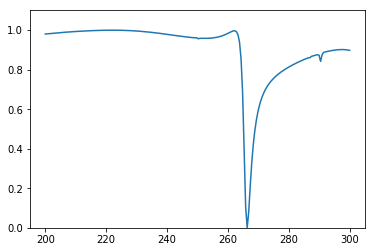

Predicted spectrum: 


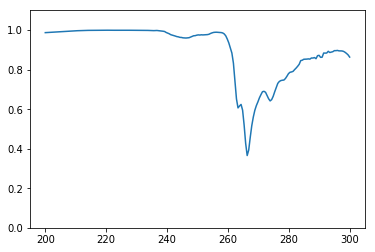

Test 3
True spectrum: 


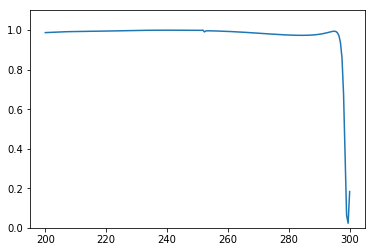

Predicted spectrum: 


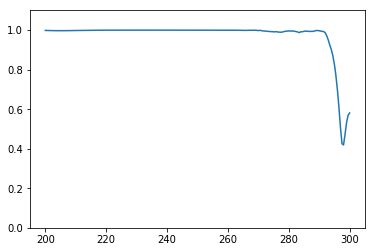

Test 4
True spectrum: 


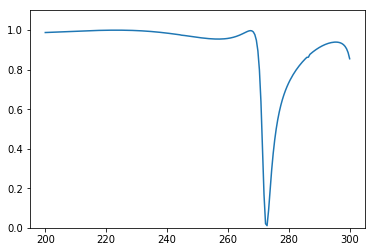

Predicted spectrum: 


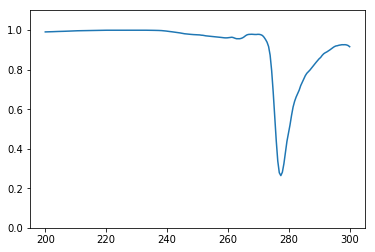

Test 5
True spectrum: 


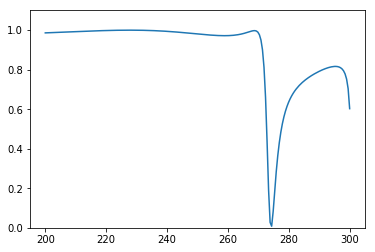

Predicted spectrum: 


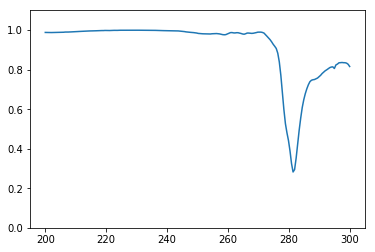

Test 6
True spectrum: 


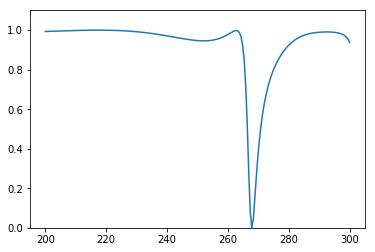

Predicted spectrum: 


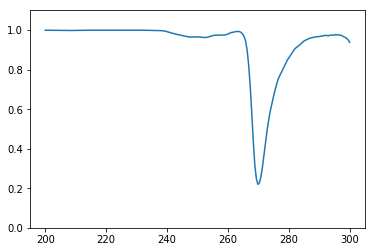

Test 7
True spectrum: 


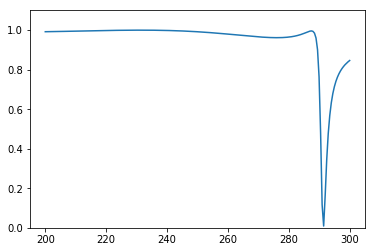

Predicted spectrum: 


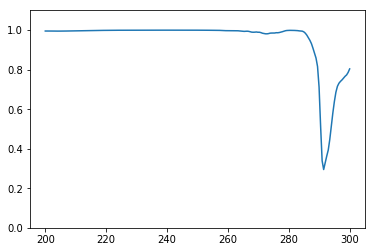

Test 8
True spectrum: 


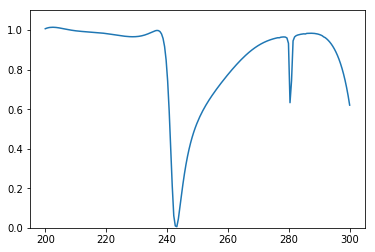

Predicted spectrum: 


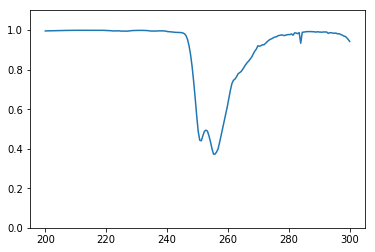

Test 9
True spectrum: 


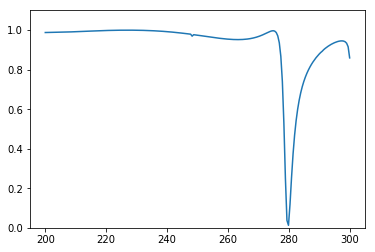

Predicted spectrum: 


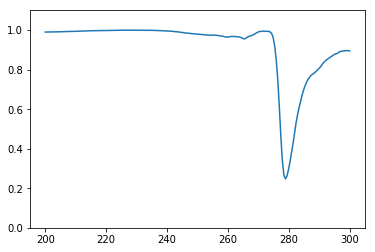

Test 10
True spectrum: 


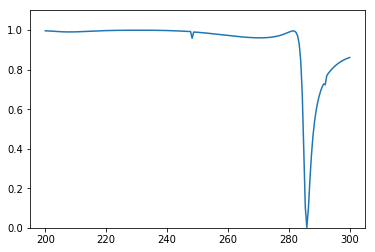

Predicted spectrum: 


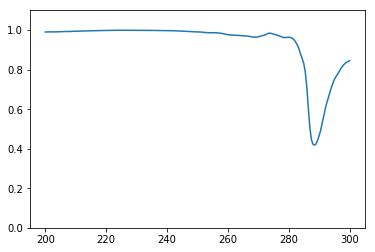

Test 11
True spectrum: 


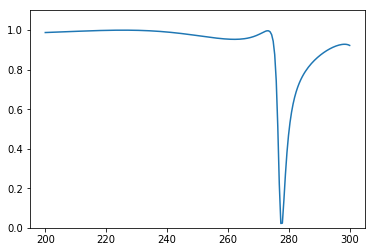

Predicted spectrum: 


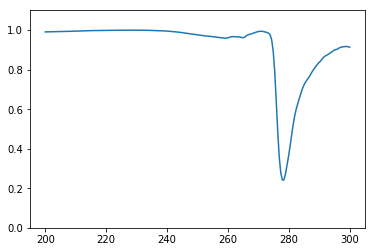

Test 12
True spectrum: 


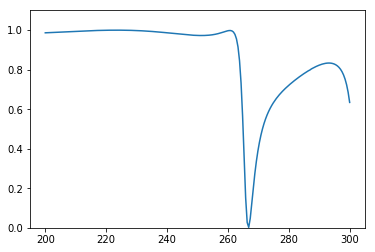

Predicted spectrum: 


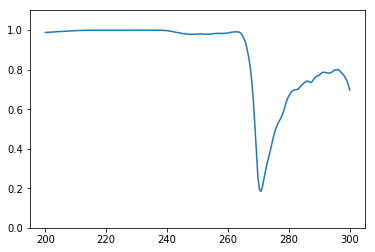

Test 13
True spectrum: 


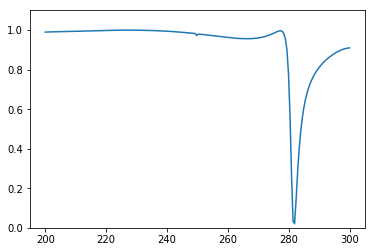

Predicted spectrum: 


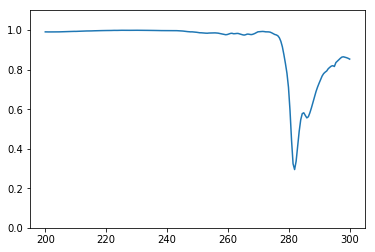

Test 14
True spectrum: 


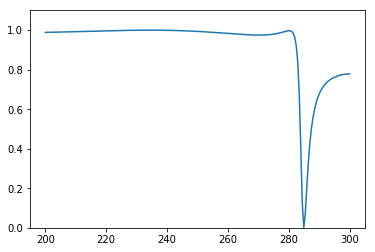

Predicted spectrum: 


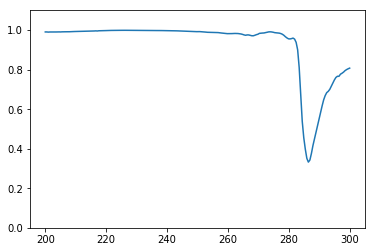

Test 15
True spectrum: 


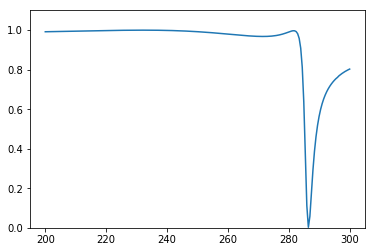

Predicted spectrum: 


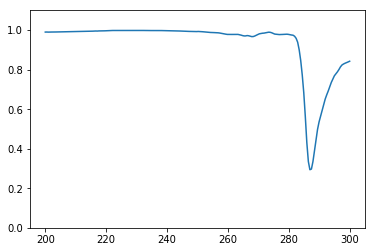

Test 16
True spectrum: 


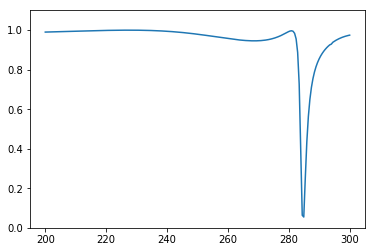

Predicted spectrum: 


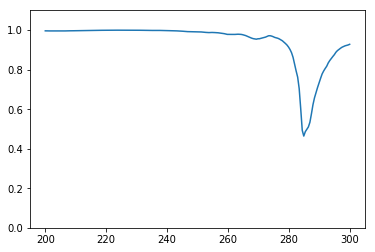

Test 17
True spectrum: 


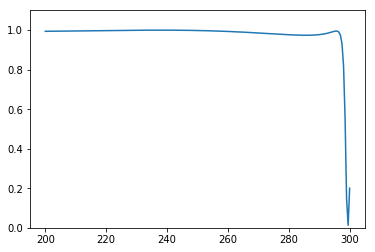

Predicted spectrum: 


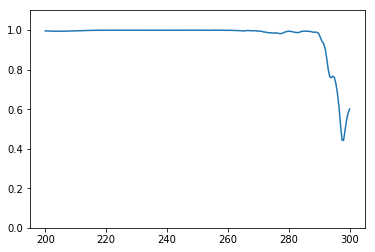

Test 18
True spectrum: 


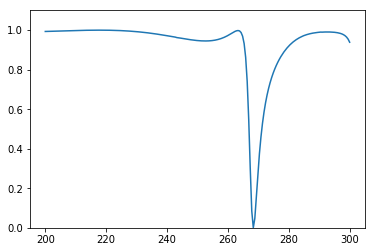

Predicted spectrum: 


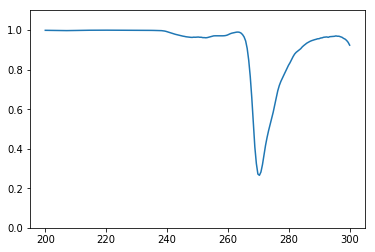

Test 19
True spectrum: 


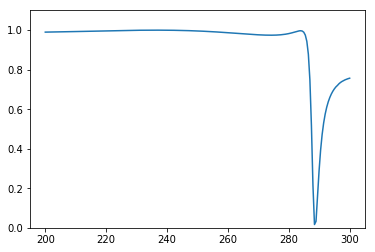

Predicted spectrum: 


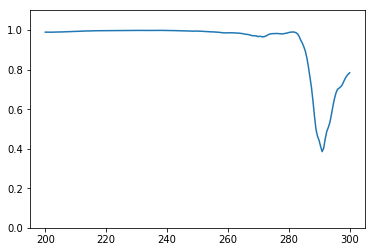

Test 20
True spectrum: 


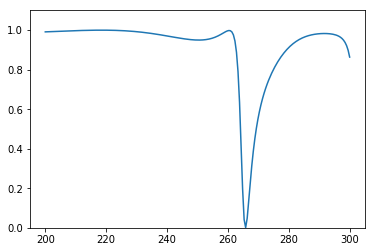

Predicted spectrum: 


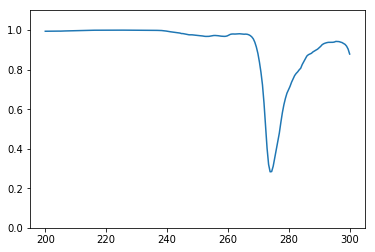

Test 21
True spectrum: 


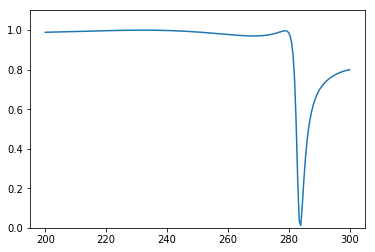

Predicted spectrum: 


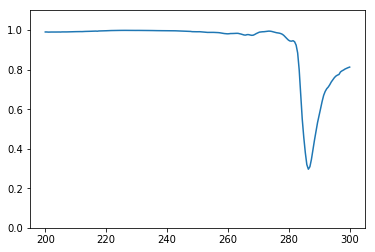

Test 22
True spectrum: 


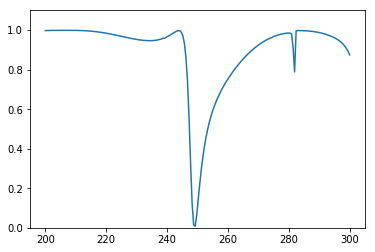

Predicted spectrum: 


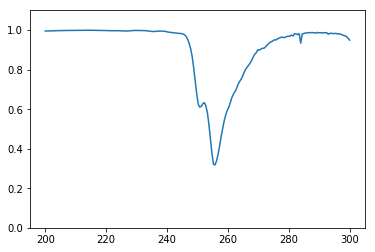

Test 23
True spectrum: 


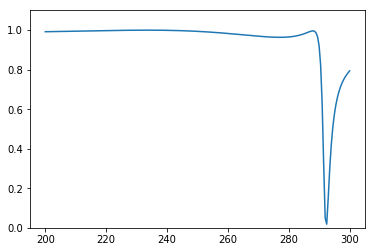

Predicted spectrum: 


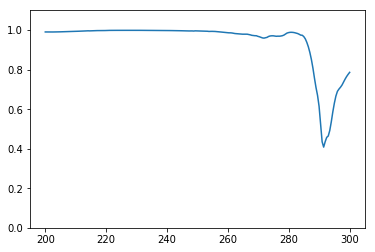

Test 24
True spectrum: 


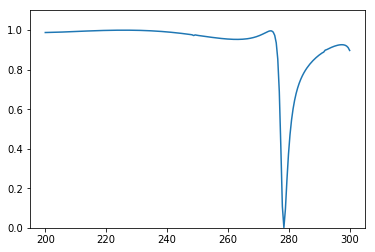

Predicted spectrum: 


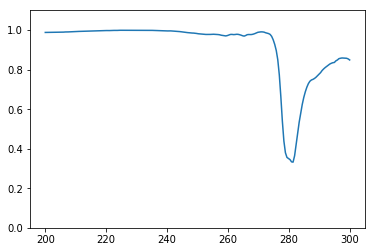

Test 25
True spectrum: 


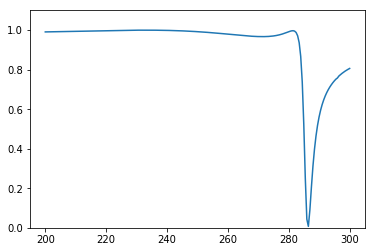

Predicted spectrum: 


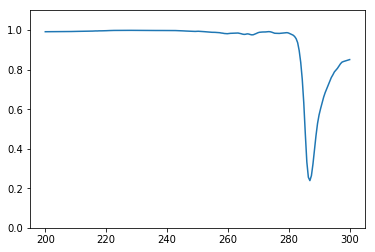

Test 26
True spectrum: 


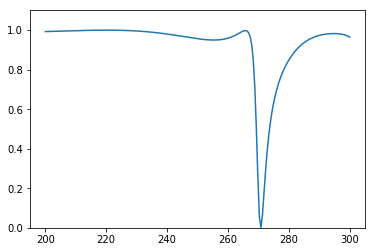

Predicted spectrum: 


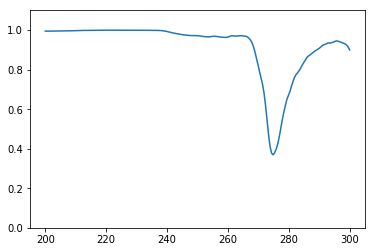

Test 27
True spectrum: 


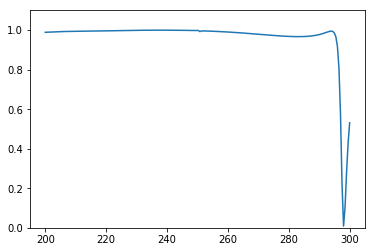

Predicted spectrum: 


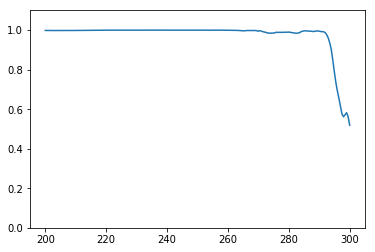

Test 28
True spectrum: 


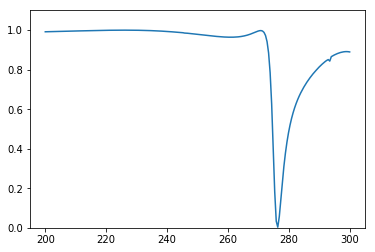

Predicted spectrum: 


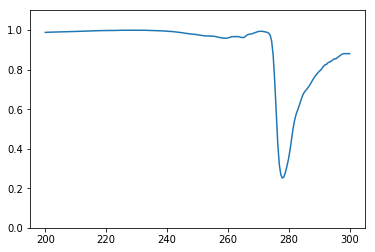

Test 29
True spectrum: 


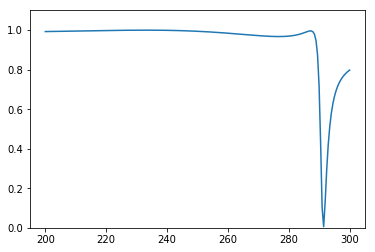

Predicted spectrum: 


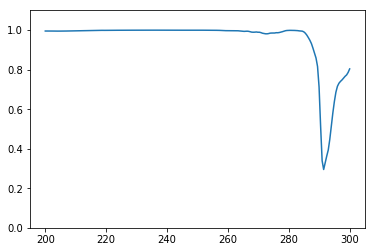

Test 30
True spectrum: 


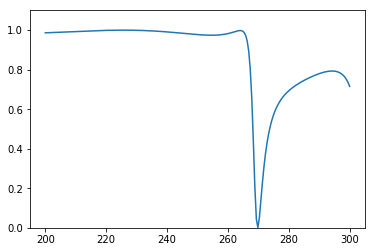

Predicted spectrum: 


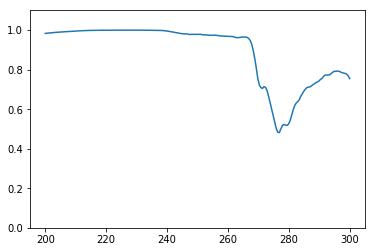

Test 31
True spectrum: 


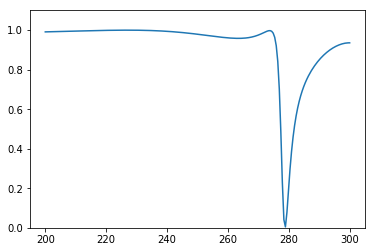

Predicted spectrum: 


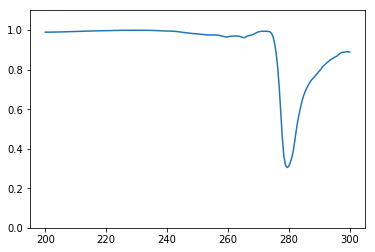

Test 32
True spectrum: 


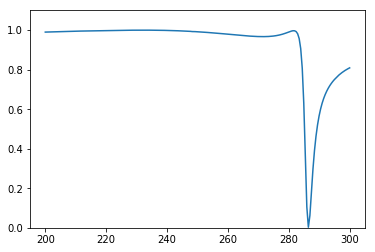

Predicted spectrum: 


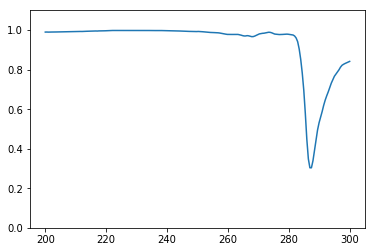

Test 33
True spectrum: 


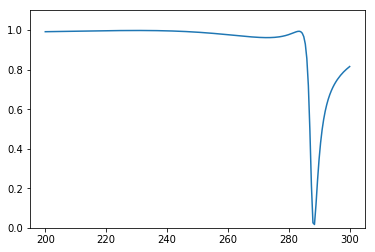

Predicted spectrum: 


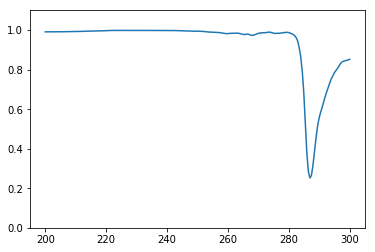

Test 34
True spectrum: 


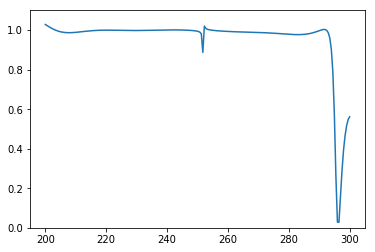

Predicted spectrum: 


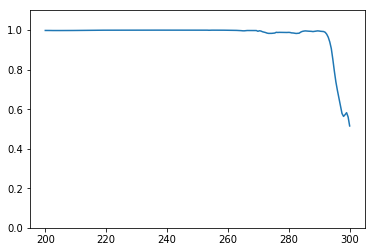

Test 35
True spectrum: 


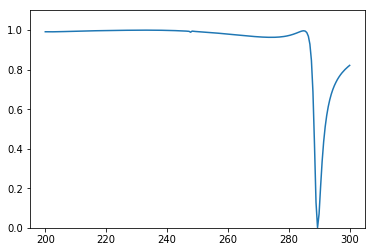

Predicted spectrum: 


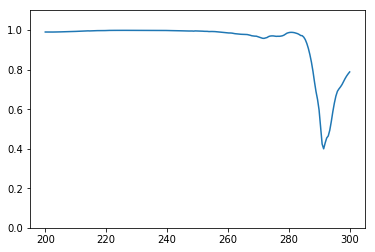

Test 36
True spectrum: 


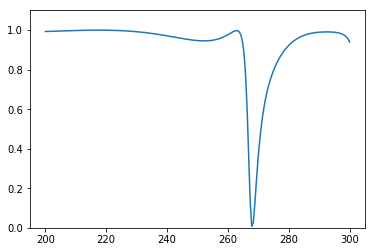

Predicted spectrum: 


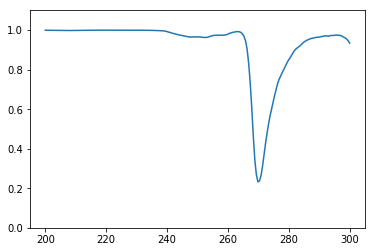

Test 37
True spectrum: 


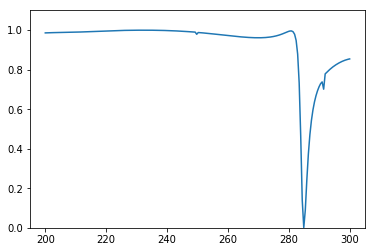

Predicted spectrum: 


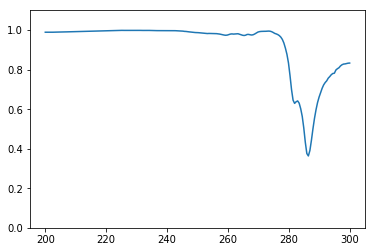

Test 38
True spectrum: 


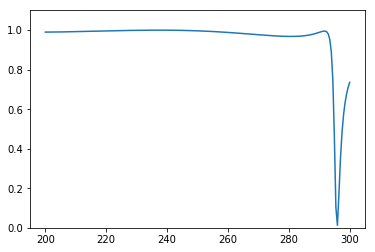

Predicted spectrum: 


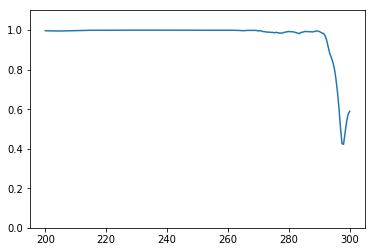

Test 39
True spectrum: 


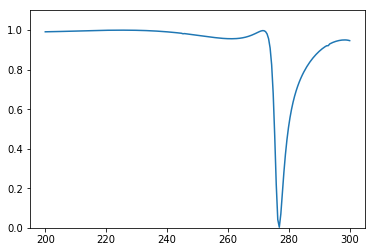

Predicted spectrum: 


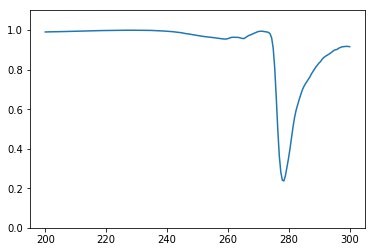

Test 40
True spectrum: 


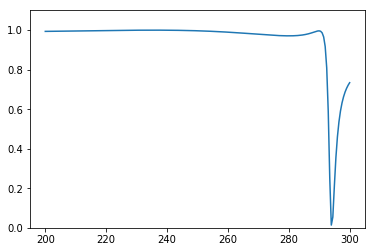

Predicted spectrum: 


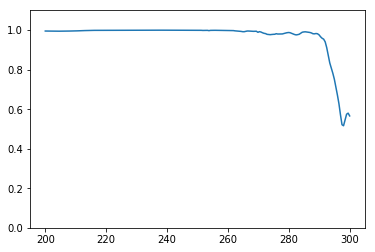

Test 41
True spectrum: 


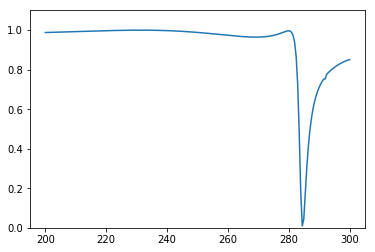

Predicted spectrum: 


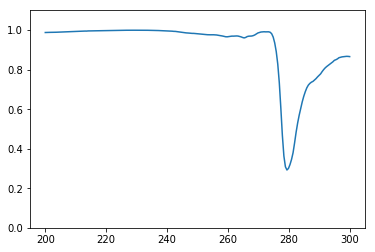

Test 42
True spectrum: 


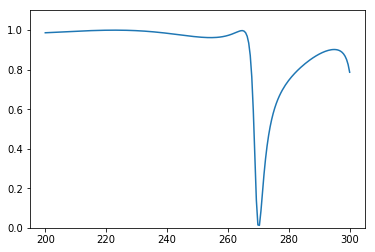

Predicted spectrum: 


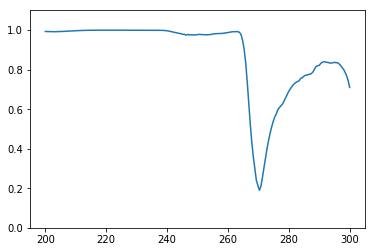

Test 43
True spectrum: 


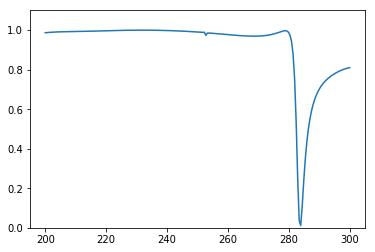

Predicted spectrum: 


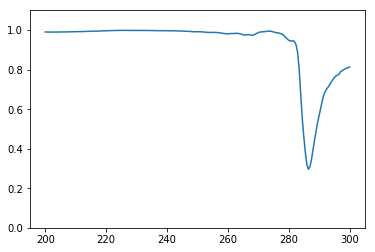

Test 44
True spectrum: 


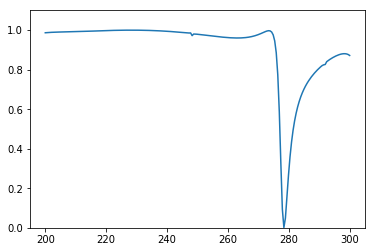

Predicted spectrum: 


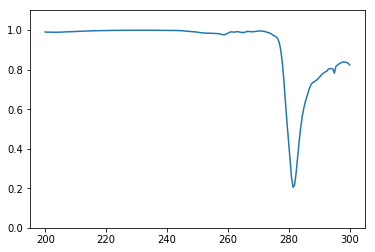

Test 45
True spectrum: 


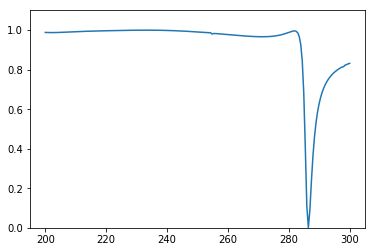

Predicted spectrum: 


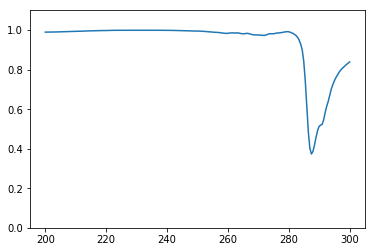

Test 46
True spectrum: 


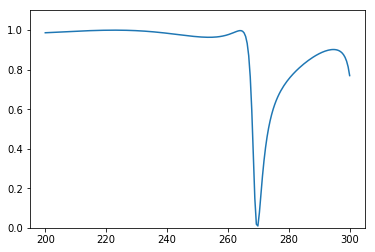

Predicted spectrum: 


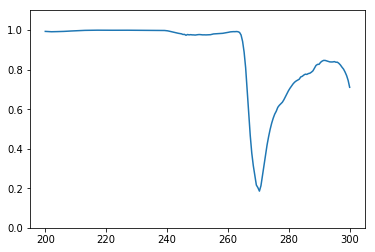

Test 47
True spectrum: 


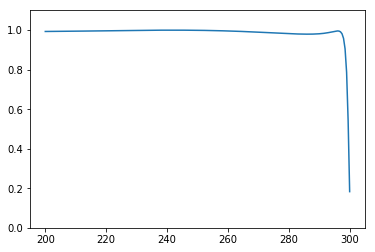

Predicted spectrum: 


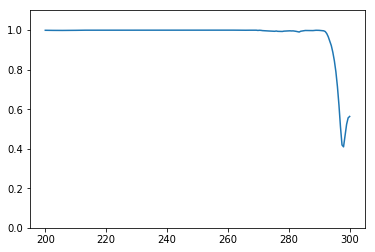

Test 48
True spectrum: 


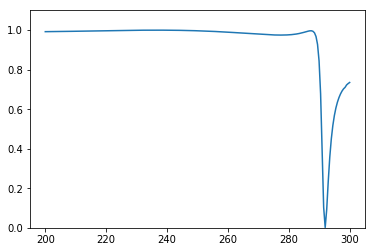

Predicted spectrum: 


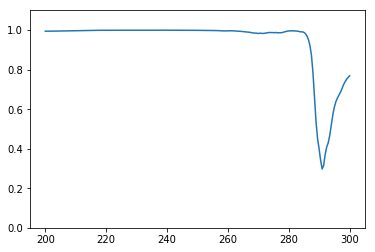

Test 49
True spectrum: 


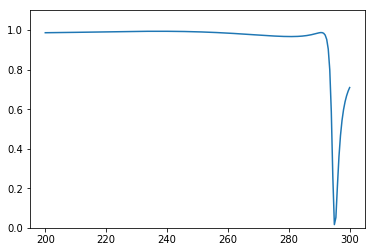

Predicted spectrum: 


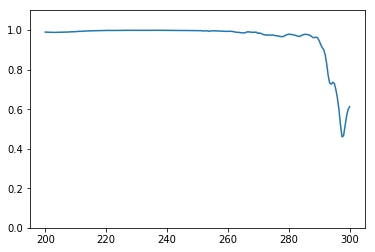

Test 50
True spectrum: 


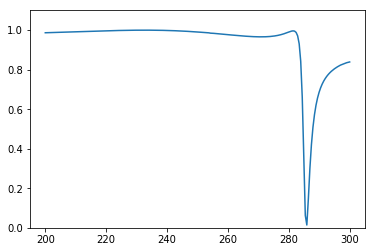

Predicted spectrum: 


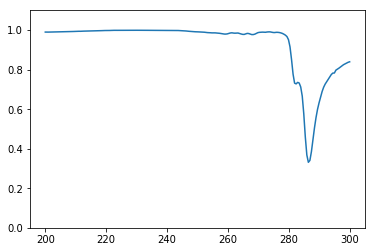

Test 51
True spectrum: 


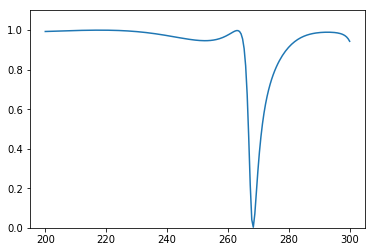

Predicted spectrum: 


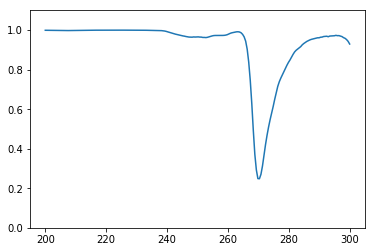

Test 52
True spectrum: 


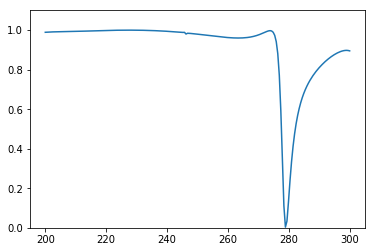

Predicted spectrum: 


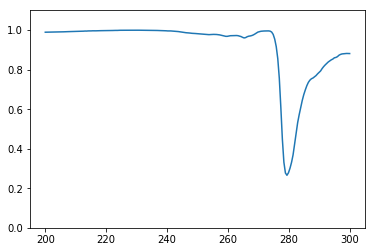

Test 53
True spectrum: 


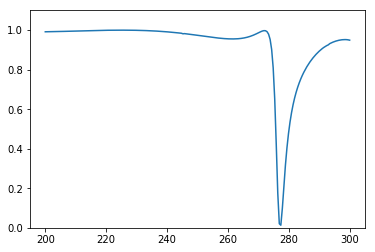

Predicted spectrum: 


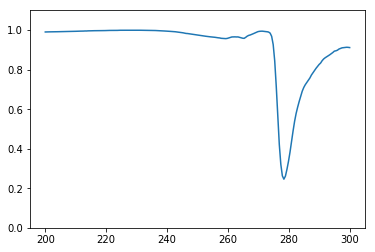

Test 54
True spectrum: 


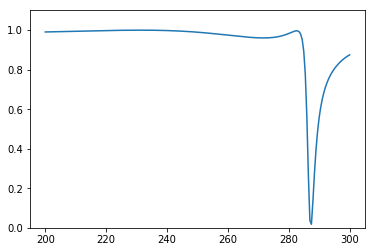

Predicted spectrum: 


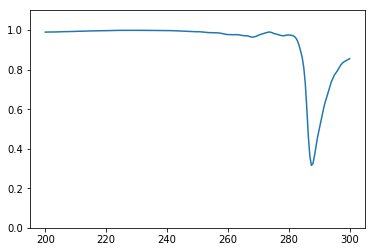

Test 55
True spectrum: 


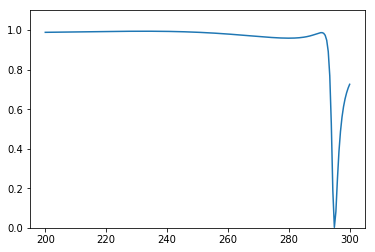

Predicted spectrum: 


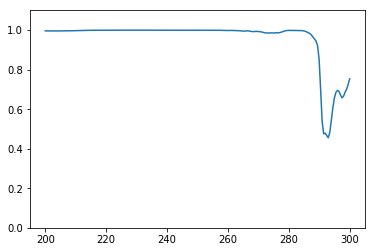

Test 56
True spectrum: 


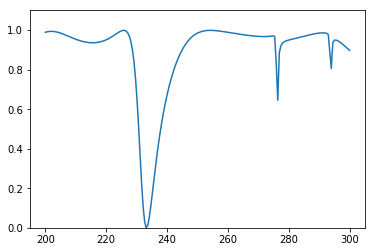

Predicted spectrum: 


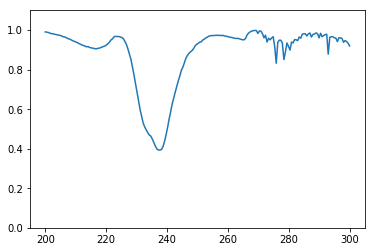

Test 57
True spectrum: 


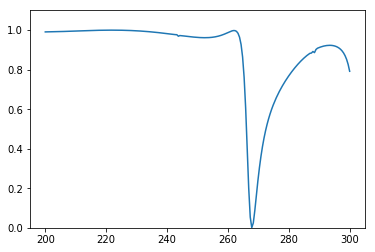

Predicted spectrum: 


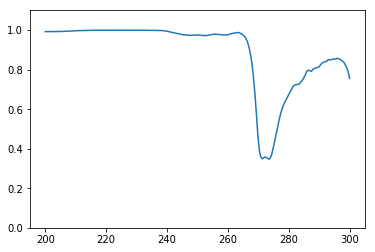

Test 58
True spectrum: 


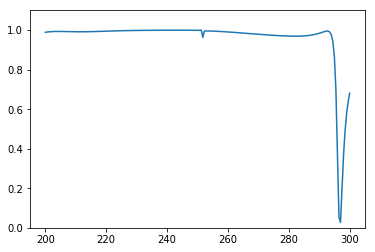

Predicted spectrum: 


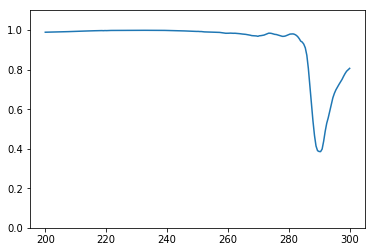

Test 59
True spectrum: 


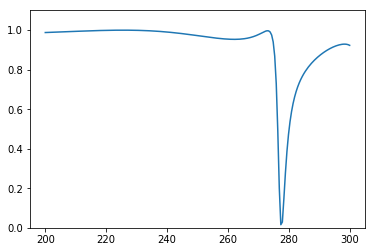

Predicted spectrum: 


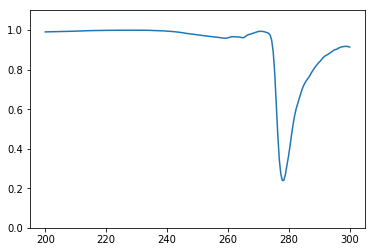

Test 60
True spectrum: 


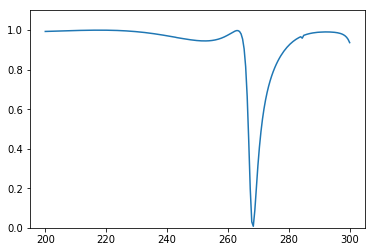

Predicted spectrum: 


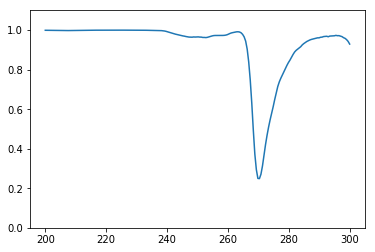

Test 61
True spectrum: 


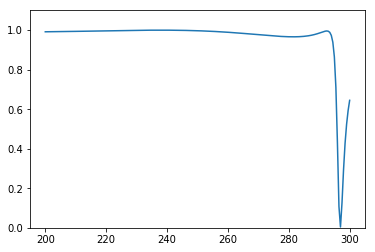

Predicted spectrum: 


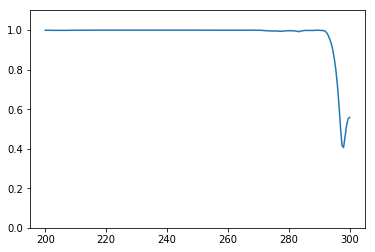

Test 62
True spectrum: 


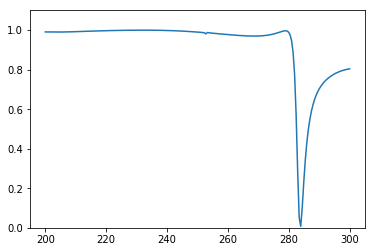

Predicted spectrum: 


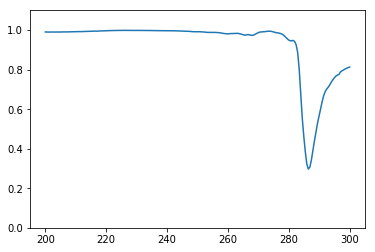

Test 63
True spectrum: 


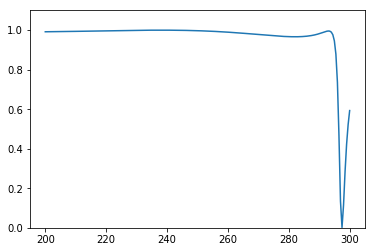

Predicted spectrum: 


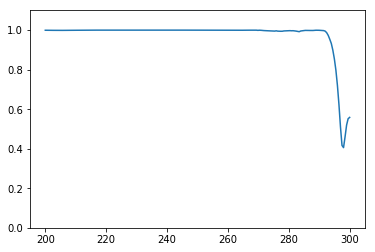

Test 64
True spectrum: 


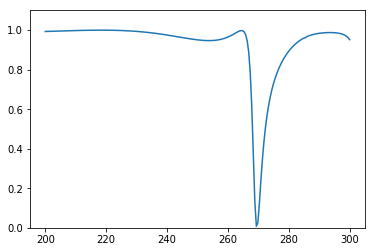

Predicted spectrum: 


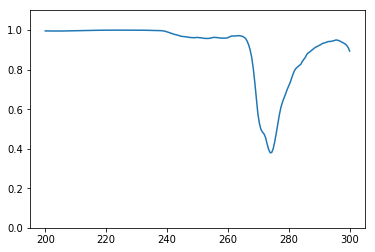

Test 65
True spectrum: 


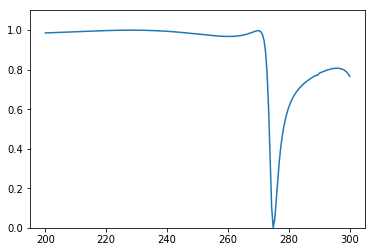

Predicted spectrum: 


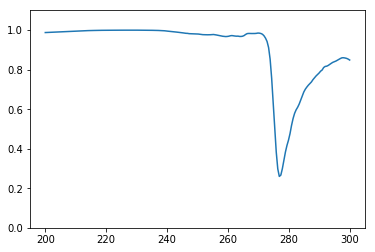

Test 66
True spectrum: 


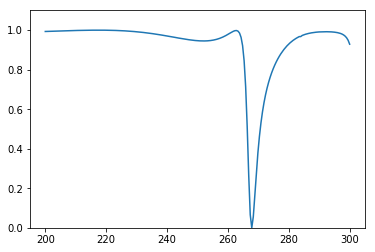

Predicted spectrum: 


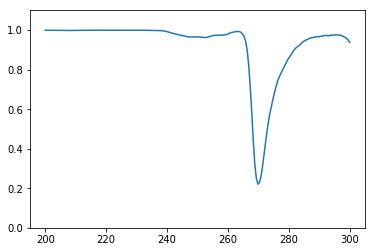

Test 67
True spectrum: 


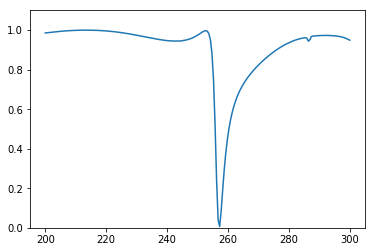

Predicted spectrum: 


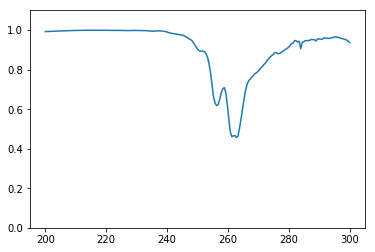

Test 68
True spectrum: 


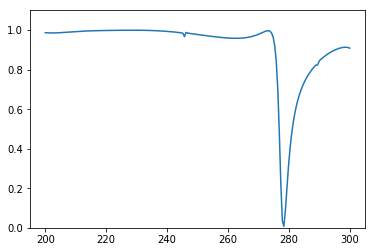

Predicted spectrum: 


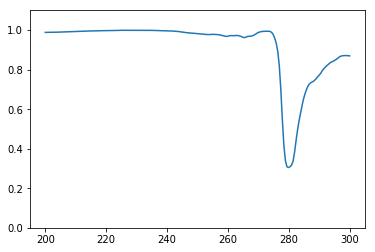

Test 69
True spectrum: 


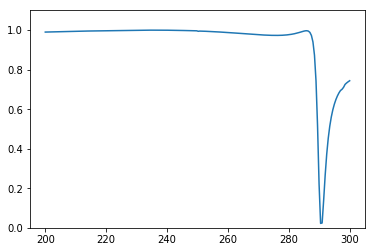

Predicted spectrum: 


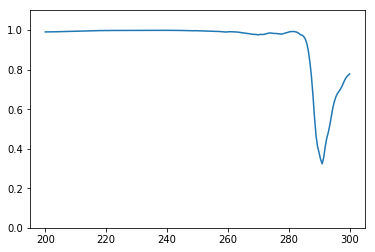

Test 70
True spectrum: 


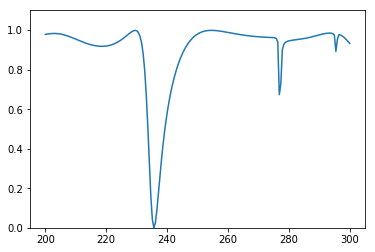

Predicted spectrum: 


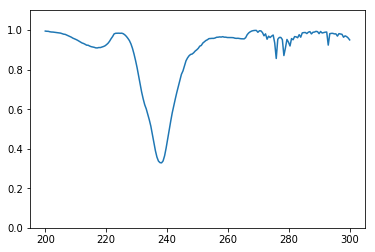

Test 71
True spectrum: 


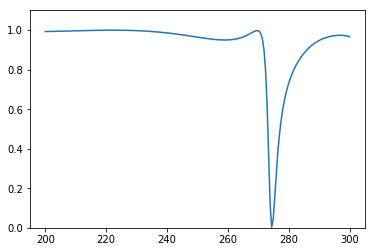

Predicted spectrum: 


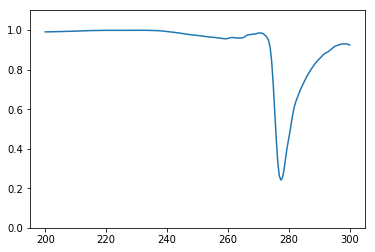

Test 72
True spectrum: 


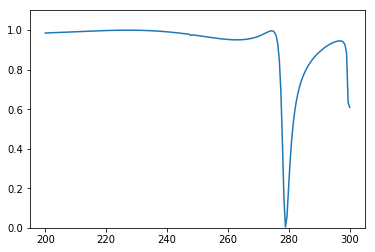

Predicted spectrum: 


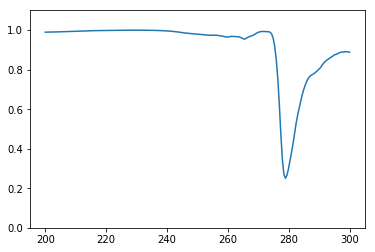

Test 73
True spectrum: 


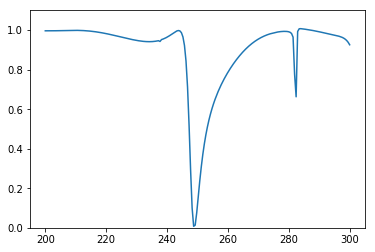

Predicted spectrum: 


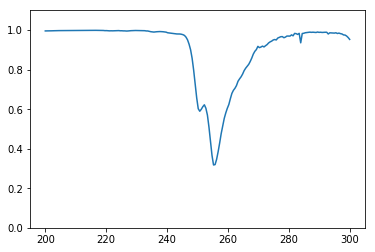

Test 74
True spectrum: 


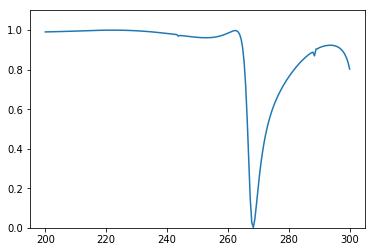

Predicted spectrum: 


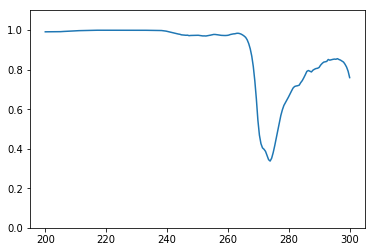

Test 75
True spectrum: 


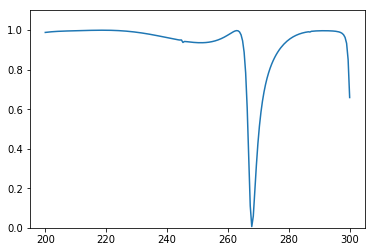

Predicted spectrum: 


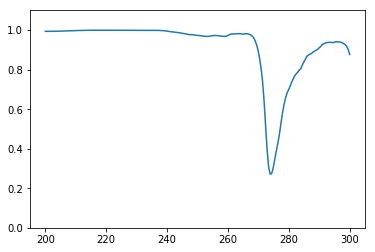

Test 76
True spectrum: 


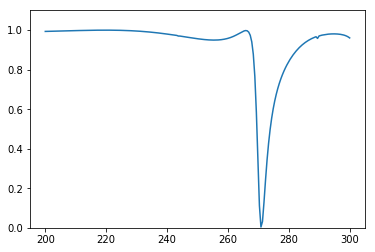

Predicted spectrum: 


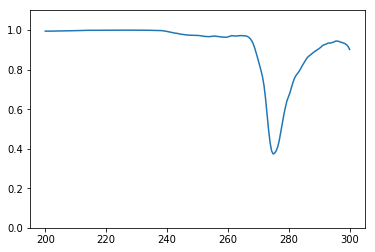

Test 77
True spectrum: 


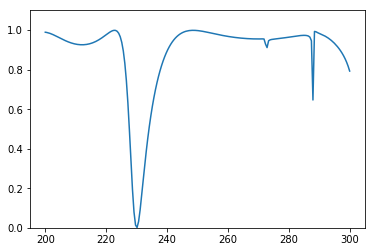

Predicted spectrum: 


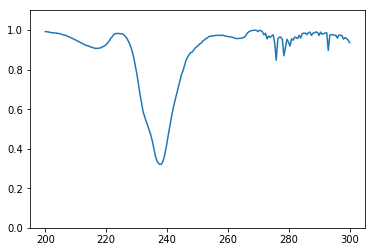

Test 78
True spectrum: 


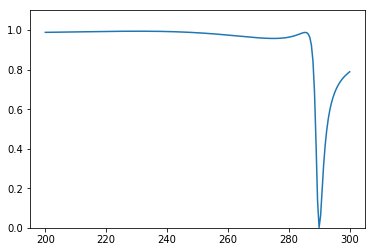

Predicted spectrum: 


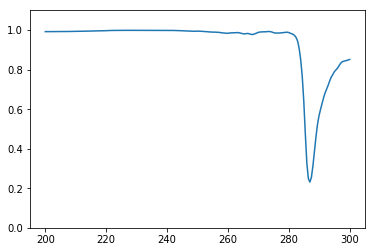

Test 79
True spectrum: 


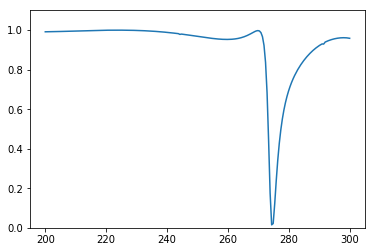

Predicted spectrum: 


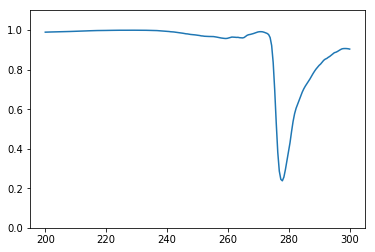

Test 80
True spectrum: 


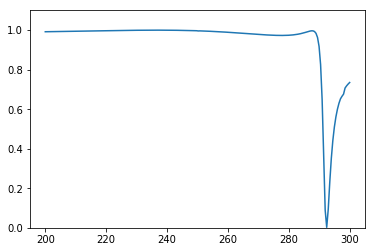

Predicted spectrum: 


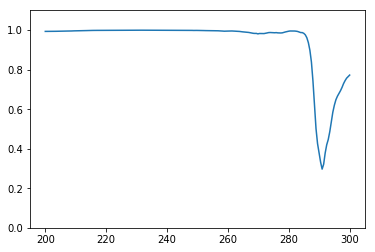

Test 81
True spectrum: 


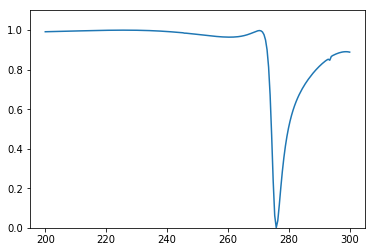

Predicted spectrum: 


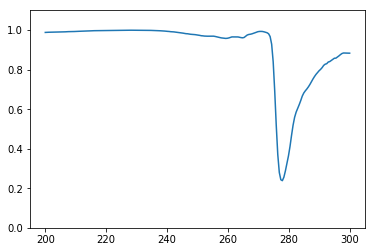

Test 82
True spectrum: 


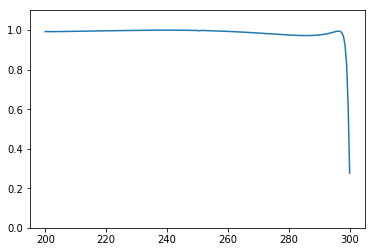

Predicted spectrum: 


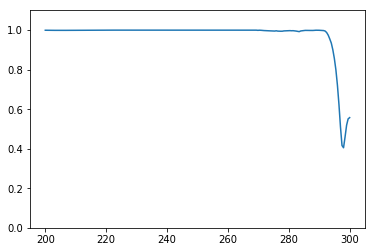

Test 83
True spectrum: 


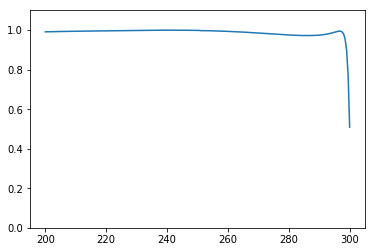

Predicted spectrum: 


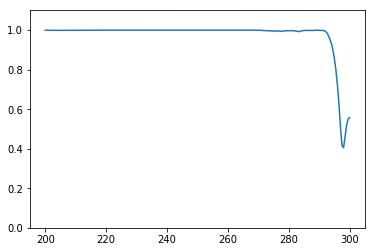

Test 84
True spectrum: 


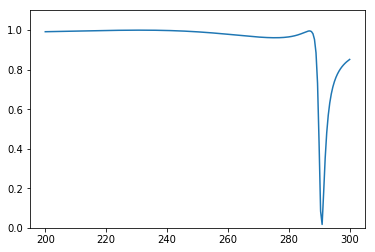

Predicted spectrum: 


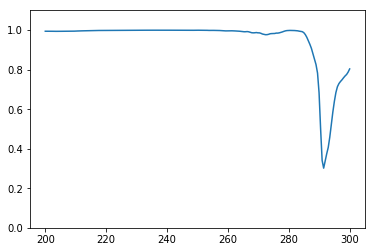

Test 85
True spectrum: 


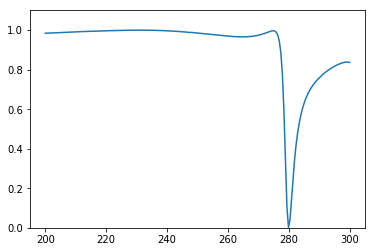

Predicted spectrum: 


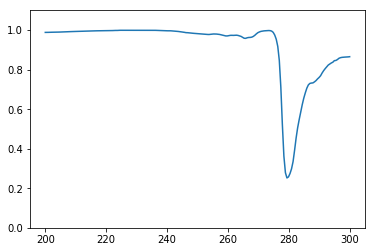

Test 86
True spectrum: 


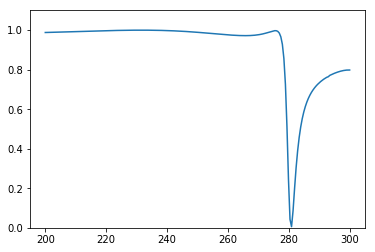

Predicted spectrum: 


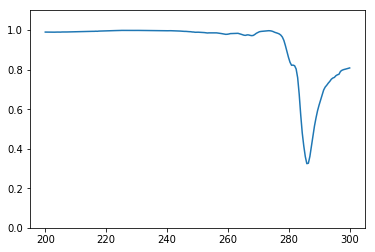

Test 87
True spectrum: 


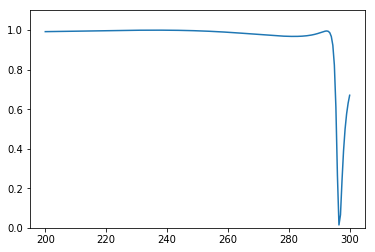

Predicted spectrum: 


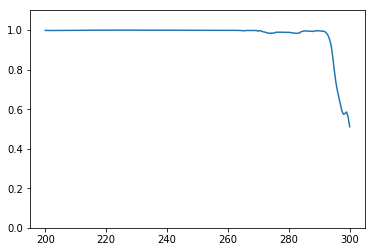

Test 88
True spectrum: 


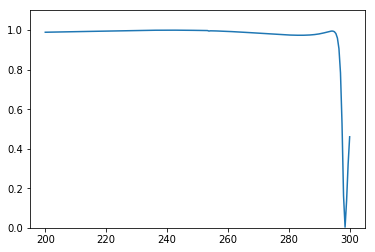

Predicted spectrum: 


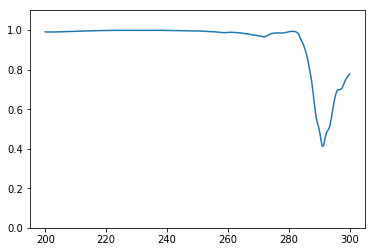

Test 89
True spectrum: 


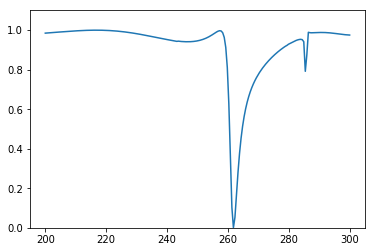

Predicted spectrum: 


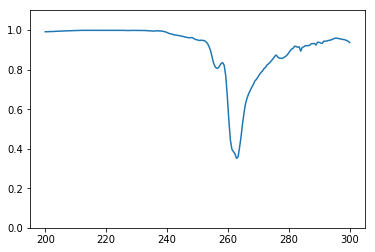

Test 90
True spectrum: 


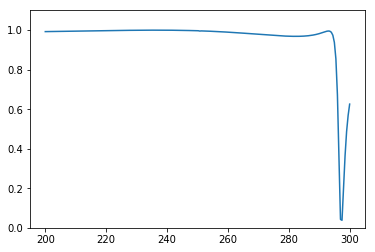

Predicted spectrum: 


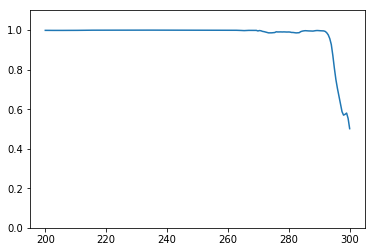

Test 91
True spectrum: 


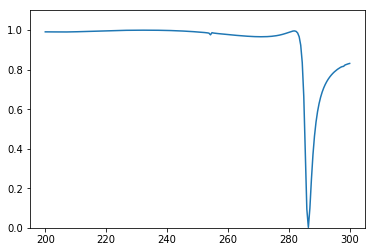

Predicted spectrum: 


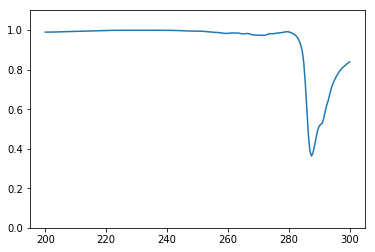

Test 92
True spectrum: 


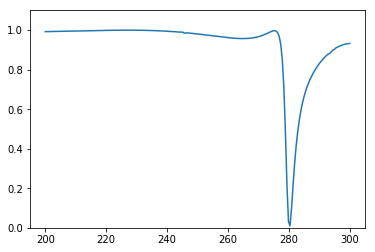

Predicted spectrum: 


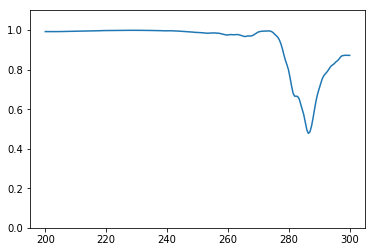

In [32]:
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(len(test_X)):
    print('Test '+str(i))
    print('True spectrum: ')
    plt.ylim(0, 1.1)
    plt.plot(x, test_Y[i])
    plt.show()
    print('Predicted spectrum: ')
    plt.ylim(0, 1.1)
    plt.plot(x, np.reshape(simulator.predict(np.reshape(test_X[i], (1, 6))), (200,)))
    plt.show()

In [33]:
for i,layer in enumerate(simulator.layers):
    print(i,layer.name)

0 dense_21
1 dropout_21
2 dense_22
3 dropout_22
4 dense_23
5 dropout_23
6 dense_24
7 dropout_24
8 dense_25
9 dropout_25
10 dense_26


In [37]:
for i,layer in enumerate(simulator.layers):
    print(i,layer.name,layer.trainable)

0 dense_21 False
1 dropout_21 False
2 dense_22 False
3 dropout_22 False
4 dense_23 False
5 dropout_23 False
6 dense_24 False
7 dropout_24 False
8 dense_25 False
9 dropout_25 False
10 dense_26 False


In [36]:
for layer in simulator.layers:
    layer.trainable=False

In [40]:
tandem = Sequential()
tandem.add(Dense(500, activation='relu', input_dim=out_dim))
tandem.add(Dropout(0.2))
tandem.add(Dense(200, activation='relu'))
tandem.add(Dropout(0.2))
tandem.add(Dense(6, activation='sigmoid'))
for layer in simulator.layers:
    tandem.add(layer)
tandem.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.Adam(lr = 0.001))

In [80]:
for layer in tandem.layers[:5]:
    layer.trainable=True
    print(i,layer.name,layer.trainable)

92 dense_30 True
92 dropout_28 True
92 dense_31 True
92 dropout_29 True
92 dense_32 True


In [81]:
tandem.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 500)               100500    
_________________________________________________________________
dropout_28 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_29 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 1206      
_________________________________________________________________
dense_21 (Dense)             (None, 20)                140       
_________________________________________________________________
dropout_21 (Dropout)         (None, 20)                0         
__________

Train on 372 samples, validate on 93 samples
Epoch 1/1500
 - 0s - loss: 0.0167 - val_loss: 0.0151
Epoch 2/1500
 - 0s - loss: 0.0166 - val_loss: 0.0132
Epoch 3/1500
 - 0s - loss: 0.0159 - val_loss: 0.0160
Epoch 4/1500
 - 0s - loss: 0.0166 - val_loss: 0.0158
Epoch 5/1500
 - 0s - loss: 0.0161 - val_loss: 0.0161
Epoch 6/1500
 - 0s - loss: 0.0159 - val_loss: 0.0162
Epoch 7/1500
 - 0s - loss: 0.0190 - val_loss: 0.0184
Epoch 8/1500
 - 0s - loss: 0.0183 - val_loss: 0.0182
Epoch 9/1500
 - 0s - loss: 0.0192 - val_loss: 0.0161
Epoch 10/1500
 - 0s - loss: 0.0185 - val_loss: 0.0169
Epoch 11/1500
 - 0s - loss: 0.0179 - val_loss: 0.0159
Epoch 12/1500
 - 0s - loss: 0.0180 - val_loss: 0.0155
Epoch 13/1500
 - 0s - loss: 0.0178 - val_loss: 0.0152
Epoch 14/1500
 - 0s - loss: 0.0180 - val_loss: 0.0150
Epoch 15/1500
 - 0s - loss: 0.0170 - val_loss: 0.0162
Epoch 16/1500
 - 0s - loss: 0.0175 - val_loss: 0.0180
Epoch 17/1500
 - 0s - loss: 0.0208 - val_loss: 0.0173
Epoch 18/1500
 - 0s - loss: 0.0178 - val_loss:

 - 0s - loss: 0.0199 - val_loss: 0.0146
Epoch 152/1500
 - 0s - loss: 0.0164 - val_loss: 0.0135
Epoch 153/1500
 - 0s - loss: 0.0156 - val_loss: 0.0145
Epoch 154/1500
 - 0s - loss: 0.0153 - val_loss: 0.0142
Epoch 155/1500
 - 0s - loss: 0.0167 - val_loss: 0.0152
Epoch 156/1500
 - 0s - loss: 0.0156 - val_loss: 0.0157
Epoch 157/1500
 - 0s - loss: 0.0157 - val_loss: 0.0155
Epoch 158/1500
 - 0s - loss: 0.0154 - val_loss: 0.0156
Epoch 159/1500
 - 0s - loss: 0.0155 - val_loss: 0.0138
Epoch 160/1500
 - 0s - loss: 0.0156 - val_loss: 0.0171
Epoch 161/1500
 - 0s - loss: 0.0167 - val_loss: 0.0127
Epoch 162/1500
 - 0s - loss: 0.0166 - val_loss: 0.0138
Epoch 163/1500
 - 0s - loss: 0.0162 - val_loss: 0.0133
Epoch 164/1500
 - 0s - loss: 0.0160 - val_loss: 0.0168
Epoch 165/1500
 - 0s - loss: 0.0166 - val_loss: 0.0134
Epoch 166/1500
 - 0s - loss: 0.0152 - val_loss: 0.0127
Epoch 167/1500
 - 0s - loss: 0.0160 - val_loss: 0.0125
Epoch 168/1500
 - 0s - loss: 0.0157 - val_loss: 0.0137
Epoch 169/1500
 - 0s - lo

 - 0s - loss: 0.0156 - val_loss: 0.0146
Epoch 301/1500
 - 0s - loss: 0.0152 - val_loss: 0.0163
Epoch 302/1500
 - 0s - loss: 0.0154 - val_loss: 0.0162
Epoch 303/1500
 - 0s - loss: 0.0160 - val_loss: 0.0166
Epoch 304/1500
 - 0s - loss: 0.0153 - val_loss: 0.0140
Epoch 305/1500
 - 0s - loss: 0.0156 - val_loss: 0.0127
Epoch 306/1500
 - 0s - loss: 0.0158 - val_loss: 0.0152
Epoch 307/1500
 - 0s - loss: 0.0156 - val_loss: 0.0165
Epoch 308/1500
 - 0s - loss: 0.0165 - val_loss: 0.0126
Epoch 309/1500
 - 0s - loss: 0.0160 - val_loss: 0.0159
Epoch 310/1500
 - 0s - loss: 0.0157 - val_loss: 0.0160
Epoch 311/1500
 - 0s - loss: 0.0153 - val_loss: 0.0169
Epoch 312/1500
 - 0s - loss: 0.0155 - val_loss: 0.0166
Epoch 313/1500
 - 0s - loss: 0.0169 - val_loss: 0.0151
Epoch 314/1500
 - 0s - loss: 0.0160 - val_loss: 0.0158
Epoch 315/1500
 - 0s - loss: 0.0153 - val_loss: 0.0149
Epoch 316/1500
 - 0s - loss: 0.0156 - val_loss: 0.0134
Epoch 317/1500
 - 0s - loss: 0.0156 - val_loss: 0.0159
Epoch 318/1500
 - 0s - lo

 - 0s - loss: 0.0157 - val_loss: 0.0163
Epoch 450/1500
 - 0s - loss: 0.0145 - val_loss: 0.0150
Epoch 451/1500
 - 0s - loss: 0.0151 - val_loss: 0.0180
Epoch 452/1500
 - 0s - loss: 0.0156 - val_loss: 0.0164
Epoch 453/1500
 - 0s - loss: 0.0144 - val_loss: 0.0156
Epoch 454/1500
 - 0s - loss: 0.0153 - val_loss: 0.0138
Epoch 455/1500
 - 0s - loss: 0.0152 - val_loss: 0.0154
Epoch 456/1500
 - 0s - loss: 0.0155 - val_loss: 0.0142
Epoch 457/1500
 - 0s - loss: 0.0152 - val_loss: 0.0152
Epoch 458/1500
 - 0s - loss: 0.0149 - val_loss: 0.0170
Epoch 459/1500
 - 0s - loss: 0.0153 - val_loss: 0.0110
Epoch 460/1500
 - 0s - loss: 0.0159 - val_loss: 0.0134
Epoch 461/1500
 - 0s - loss: 0.0148 - val_loss: 0.0141
Epoch 462/1500
 - 0s - loss: 0.0163 - val_loss: 0.0138
Epoch 463/1500
 - 0s - loss: 0.0148 - val_loss: 0.0153
Epoch 464/1500
 - 0s - loss: 0.0157 - val_loss: 0.0125
Epoch 465/1500
 - 0s - loss: 0.0154 - val_loss: 0.0159
Epoch 466/1500
 - 0s - loss: 0.0158 - val_loss: 0.0149
Epoch 467/1500
 - 0s - lo

Epoch 599/1500
 - 0s - loss: 0.0149 - val_loss: 0.0129
Epoch 600/1500
 - 0s - loss: 0.0155 - val_loss: 0.0141
Epoch 601/1500
 - 0s - loss: 0.0157 - val_loss: 0.0147
Epoch 602/1500
 - 0s - loss: 0.0153 - val_loss: 0.0168
Epoch 603/1500
 - 0s - loss: 0.0154 - val_loss: 0.0122
Epoch 604/1500
 - 0s - loss: 0.0151 - val_loss: 0.0198
Epoch 605/1500
 - 0s - loss: 0.0147 - val_loss: 0.0133
Epoch 606/1500
 - 0s - loss: 0.0147 - val_loss: 0.0131
Epoch 607/1500
 - 0s - loss: 0.0157 - val_loss: 0.0137
Epoch 608/1500
 - 0s - loss: 0.0157 - val_loss: 0.0138
Epoch 609/1500
 - 0s - loss: 0.0152 - val_loss: 0.0127
Epoch 610/1500
 - 0s - loss: 0.0150 - val_loss: 0.0174
Epoch 611/1500
 - 0s - loss: 0.0154 - val_loss: 0.0129
Epoch 612/1500
 - 0s - loss: 0.0146 - val_loss: 0.0165
Epoch 613/1500
 - 0s - loss: 0.0148 - val_loss: 0.0149
Epoch 614/1500
 - 0s - loss: 0.0146 - val_loss: 0.0144
Epoch 615/1500
 - 0s - loss: 0.0147 - val_loss: 0.0130
Epoch 616/1500
 - 0s - loss: 0.0149 - val_loss: 0.0123
Epoch 617/

Epoch 748/1500
 - 0s - loss: 0.0157 - val_loss: 0.0161
Epoch 749/1500
 - 0s - loss: 0.0150 - val_loss: 0.0125
Epoch 750/1500
 - 0s - loss: 0.0150 - val_loss: 0.0145
Epoch 751/1500
 - 0s - loss: 0.0145 - val_loss: 0.0151
Epoch 752/1500
 - 0s - loss: 0.0146 - val_loss: 0.0173
Epoch 753/1500
 - 0s - loss: 0.0154 - val_loss: 0.0193
Epoch 754/1500
 - 0s - loss: 0.0171 - val_loss: 0.0161
Epoch 755/1500
 - 0s - loss: 0.0169 - val_loss: 0.0136
Epoch 756/1500
 - 0s - loss: 0.0155 - val_loss: 0.0127
Epoch 757/1500
 - 0s - loss: 0.0162 - val_loss: 0.0107
Epoch 758/1500
 - 0s - loss: 0.0167 - val_loss: 0.0131
Epoch 759/1500
 - 0s - loss: 0.0152 - val_loss: 0.0131
Epoch 760/1500
 - 0s - loss: 0.0156 - val_loss: 0.0142
Epoch 761/1500
 - 0s - loss: 0.0150 - val_loss: 0.0130
Epoch 762/1500
 - 0s - loss: 0.0159 - val_loss: 0.0143
Epoch 763/1500
 - 0s - loss: 0.0154 - val_loss: 0.0181
Epoch 764/1500
 - 0s - loss: 0.0152 - val_loss: 0.0110
Epoch 765/1500
 - 0s - loss: 0.0150 - val_loss: 0.0144
Epoch 766/

Epoch 897/1500
 - 0s - loss: 0.0150 - val_loss: 0.0133
Epoch 898/1500
 - 0s - loss: 0.0145 - val_loss: 0.0139
Epoch 899/1500
 - 0s - loss: 0.0144 - val_loss: 0.0129
Epoch 900/1500
 - 0s - loss: 0.0149 - val_loss: 0.0121
Epoch 901/1500
 - 0s - loss: 0.0141 - val_loss: 0.0151
Epoch 902/1500
 - 0s - loss: 0.0156 - val_loss: 0.0133
Epoch 903/1500
 - 0s - loss: 0.0159 - val_loss: 0.0130
Epoch 904/1500
 - 0s - loss: 0.0156 - val_loss: 0.0131
Epoch 905/1500
 - 0s - loss: 0.0152 - val_loss: 0.0159
Epoch 906/1500
 - 0s - loss: 0.0155 - val_loss: 0.0157
Epoch 907/1500
 - 0s - loss: 0.0159 - val_loss: 0.0167
Epoch 908/1500
 - 0s - loss: 0.0145 - val_loss: 0.0146
Epoch 909/1500
 - 0s - loss: 0.0146 - val_loss: 0.0134
Epoch 910/1500
 - 0s - loss: 0.0144 - val_loss: 0.0131
Epoch 911/1500
 - 0s - loss: 0.0148 - val_loss: 0.0132
Epoch 912/1500
 - 0s - loss: 0.0142 - val_loss: 0.0150
Epoch 913/1500
 - 0s - loss: 0.0149 - val_loss: 0.0144
Epoch 914/1500
 - 0s - loss: 0.0140 - val_loss: 0.0138
Epoch 915/

 - 0s - loss: 0.0148 - val_loss: 0.0155
Epoch 1046/1500
 - 0s - loss: 0.0142 - val_loss: 0.0136
Epoch 1047/1500
 - 0s - loss: 0.0151 - val_loss: 0.0126
Epoch 1048/1500
 - 0s - loss: 0.0139 - val_loss: 0.0154
Epoch 1049/1500
 - 0s - loss: 0.0152 - val_loss: 0.0222
Epoch 1050/1500
 - 0s - loss: 0.0172 - val_loss: 0.0135
Epoch 1051/1500
 - 0s - loss: 0.0167 - val_loss: 0.0117
Epoch 1052/1500
 - 0s - loss: 0.0162 - val_loss: 0.0184
Epoch 1053/1500
 - 0s - loss: 0.0177 - val_loss: 0.0182
Epoch 1054/1500
 - 0s - loss: 0.0161 - val_loss: 0.0142
Epoch 1055/1500
 - 0s - loss: 0.0154 - val_loss: 0.0149
Epoch 1056/1500
 - 0s - loss: 0.0150 - val_loss: 0.0125
Epoch 1057/1500
 - 0s - loss: 0.0150 - val_loss: 0.0134
Epoch 1058/1500
 - 0s - loss: 0.0152 - val_loss: 0.0169
Epoch 1059/1500
 - 0s - loss: 0.0158 - val_loss: 0.0139
Epoch 1060/1500
 - 0s - loss: 0.0153 - val_loss: 0.0121
Epoch 1061/1500
 - 0s - loss: 0.0153 - val_loss: 0.0137
Epoch 1062/1500
 - 0s - loss: 0.0146 - val_loss: 0.0137
Epoch 10

Epoch 1192/1500
 - 0s - loss: 0.0146 - val_loss: 0.0128
Epoch 1193/1500
 - 0s - loss: 0.0155 - val_loss: 0.0135
Epoch 1194/1500
 - 0s - loss: 0.0146 - val_loss: 0.0170
Epoch 1195/1500
 - 0s - loss: 0.0150 - val_loss: 0.0123
Epoch 1196/1500
 - 0s - loss: 0.0139 - val_loss: 0.0143
Epoch 1197/1500
 - 0s - loss: 0.0152 - val_loss: 0.0151
Epoch 1198/1500
 - 0s - loss: 0.0148 - val_loss: 0.0145
Epoch 1199/1500
 - 0s - loss: 0.0164 - val_loss: 0.0176
Epoch 1200/1500
 - 0s - loss: 0.0157 - val_loss: 0.0124
Epoch 1201/1500
 - 0s - loss: 0.0148 - val_loss: 0.0149
Epoch 1202/1500
 - 0s - loss: 0.0141 - val_loss: 0.0132
Epoch 1203/1500
 - 0s - loss: 0.0146 - val_loss: 0.0142
Epoch 1204/1500
 - 0s - loss: 0.0147 - val_loss: 0.0121
Epoch 1205/1500
 - 0s - loss: 0.0142 - val_loss: 0.0140
Epoch 1206/1500
 - 0s - loss: 0.0144 - val_loss: 0.0132
Epoch 1207/1500
 - 0s - loss: 0.0145 - val_loss: 0.0150
Epoch 1208/1500
 - 0s - loss: 0.0144 - val_loss: 0.0147
Epoch 1209/1500
 - 0s - loss: 0.0151 - val_loss:

Epoch 1339/1500
 - 0s - loss: 0.0141 - val_loss: 0.0146
Epoch 1340/1500
 - 0s - loss: 0.0141 - val_loss: 0.0149
Epoch 1341/1500
 - 0s - loss: 0.0149 - val_loss: 0.0139
Epoch 1342/1500
 - 0s - loss: 0.0147 - val_loss: 0.0144
Epoch 1343/1500
 - 0s - loss: 0.0150 - val_loss: 0.0130
Epoch 1344/1500
 - 0s - loss: 0.0145 - val_loss: 0.0132
Epoch 1345/1500
 - 0s - loss: 0.0143 - val_loss: 0.0125
Epoch 1346/1500
 - 0s - loss: 0.0144 - val_loss: 0.0140
Epoch 1347/1500
 - 0s - loss: 0.0146 - val_loss: 0.0150
Epoch 1348/1500
 - 0s - loss: 0.0150 - val_loss: 0.0131
Epoch 1349/1500
 - 0s - loss: 0.0148 - val_loss: 0.0148
Epoch 1350/1500
 - 0s - loss: 0.0142 - val_loss: 0.0127
Epoch 1351/1500
 - 0s - loss: 0.0143 - val_loss: 0.0135
Epoch 1352/1500
 - 0s - loss: 0.0150 - val_loss: 0.0148
Epoch 1353/1500
 - 0s - loss: 0.0135 - val_loss: 0.0135
Epoch 1354/1500
 - 0s - loss: 0.0144 - val_loss: 0.0136
Epoch 1355/1500
 - 0s - loss: 0.0147 - val_loss: 0.0143
Epoch 1356/1500
 - 0s - loss: 0.0146 - val_loss:

Epoch 1486/1500
 - 0s - loss: 0.0152 - val_loss: 0.0133
Epoch 1487/1500
 - 0s - loss: 0.0140 - val_loss: 0.0134
Epoch 1488/1500
 - 0s - loss: 0.0155 - val_loss: 0.0166
Epoch 1489/1500
 - 0s - loss: 0.0149 - val_loss: 0.0123
Epoch 1490/1500
 - 0s - loss: 0.0146 - val_loss: 0.0141
Epoch 1491/1500
 - 0s - loss: 0.0143 - val_loss: 0.0148
Epoch 1492/1500
 - 0s - loss: 0.0147 - val_loss: 0.0134
Epoch 1493/1500
 - 0s - loss: 0.0140 - val_loss: 0.0130
Epoch 1494/1500
 - 0s - loss: 0.0145 - val_loss: 0.0122
Epoch 1495/1500
 - 0s - loss: 0.0169 - val_loss: 0.0216
Epoch 1496/1500
 - 0s - loss: 0.0181 - val_loss: 0.0140
Epoch 1497/1500
 - 0s - loss: 0.0167 - val_loss: 0.0137
Epoch 1498/1500
 - 0s - loss: 0.0160 - val_loss: 0.0156
Epoch 1499/1500
 - 0s - loss: 0.0156 - val_loss: 0.0122
Epoch 1500/1500
 - 0s - loss: 0.0150 - val_loss: 0.0135
93/93 [==============================] - 0s 213us/step
0.01443604483038828
0.013548912530544625


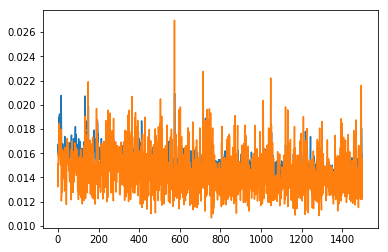

In [82]:
history = tandem.fit(train_Y, train_Y, 
                    epochs=1500, 
                    batch_size=20,
                    validation_data=(test_Y, test_Y), 
                    verbose=2)

train_score = tandem.evaluate(train_Y, train_Y, batch_size=20)
test_score = tandem.evaluate(test_Y, test_Y, batch_size= 50)
print(train_score)
print(test_score)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

Test 0
True spectrum: 


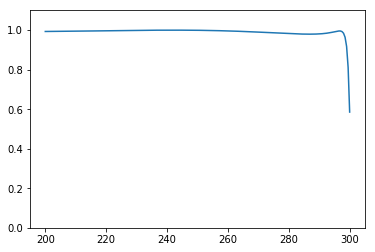

Predicted spectrum: 


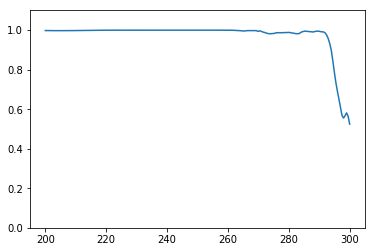

Test 1
True spectrum: 


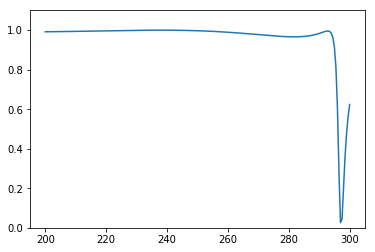

Predicted spectrum: 


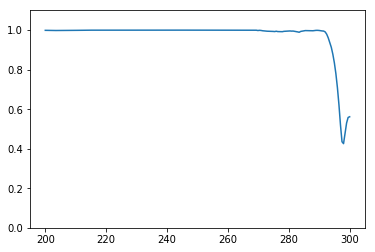

Test 2
True spectrum: 


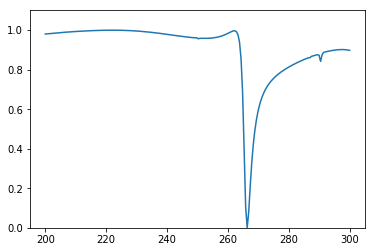

Predicted spectrum: 


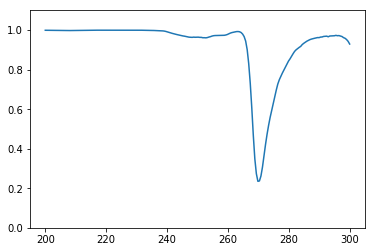

Test 3
True spectrum: 


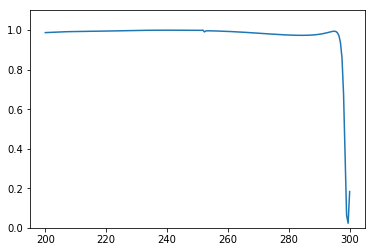

Predicted spectrum: 


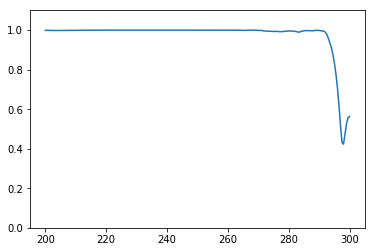

Test 4
True spectrum: 


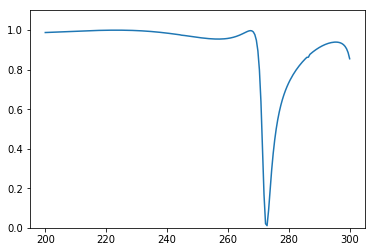

Predicted spectrum: 


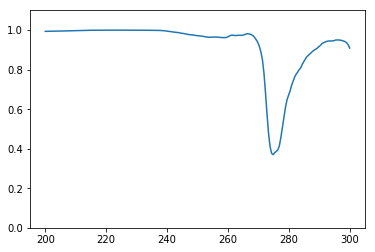

Test 5
True spectrum: 


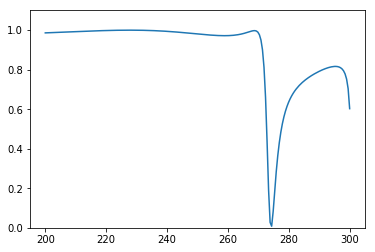

Predicted spectrum: 


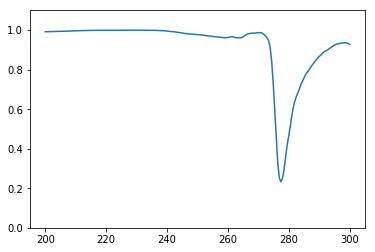

Test 6
True spectrum: 


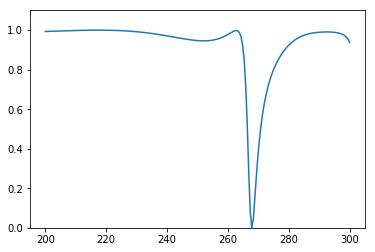

Predicted spectrum: 


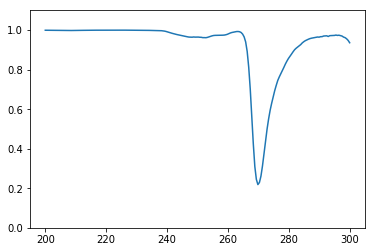

Test 7
True spectrum: 


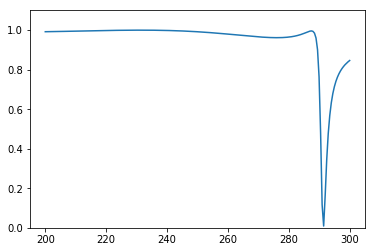

Predicted spectrum: 


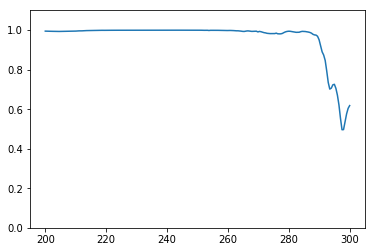

Test 8
True spectrum: 


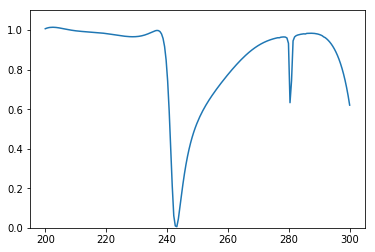

Predicted spectrum: 


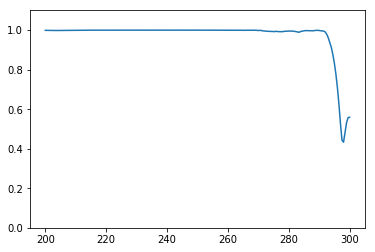

Test 9
True spectrum: 


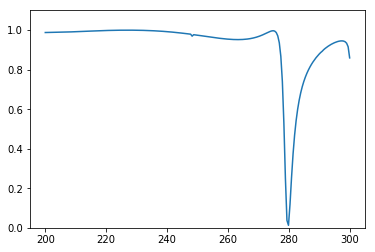

Predicted spectrum: 


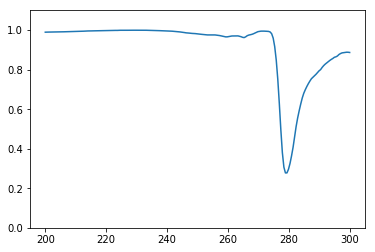

Test 10
True spectrum: 


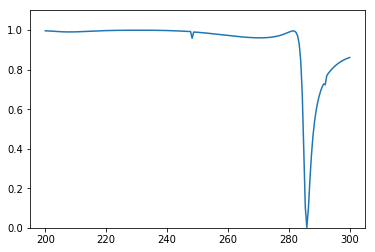

Predicted spectrum: 


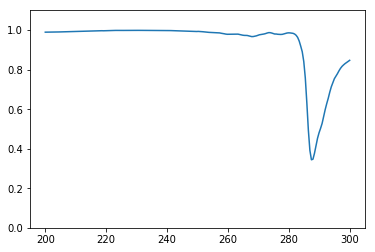

Test 11
True spectrum: 


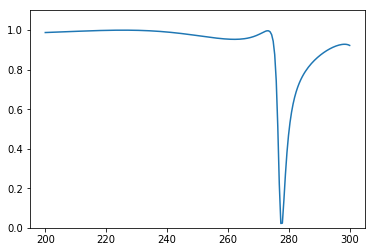

Predicted spectrum: 


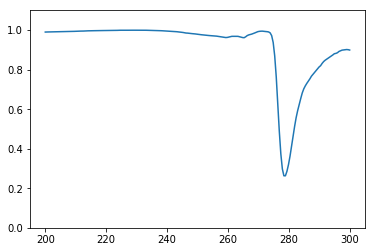

Test 12
True spectrum: 


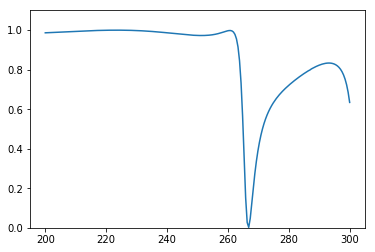

Predicted spectrum: 


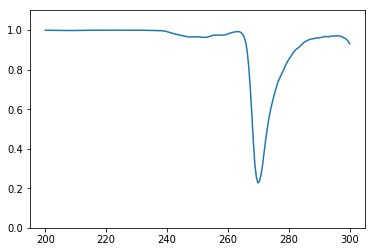

Test 13
True spectrum: 


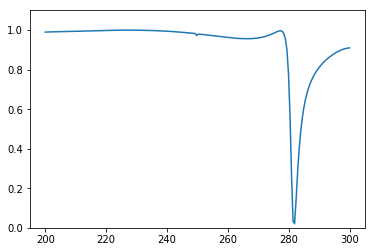

Predicted spectrum: 


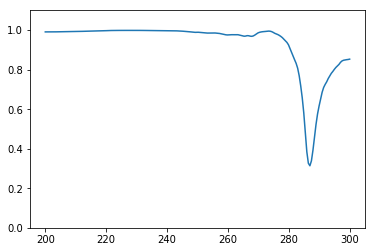

Test 14
True spectrum: 


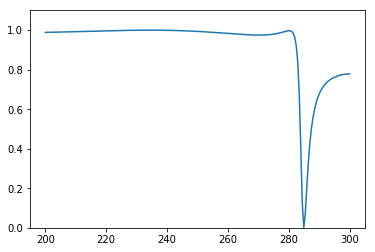

Predicted spectrum: 


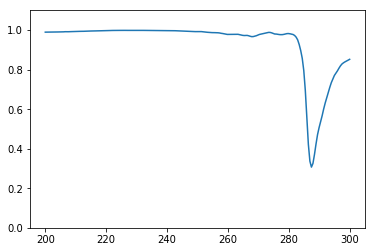

Test 15
True spectrum: 


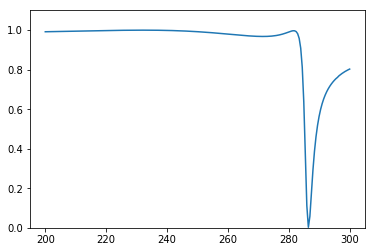

Predicted spectrum: 


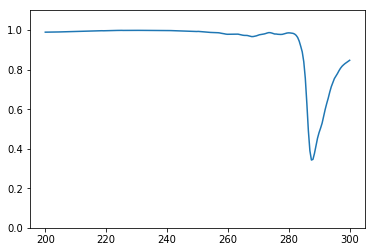

Test 16
True spectrum: 


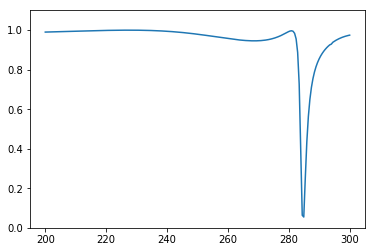

Predicted spectrum: 


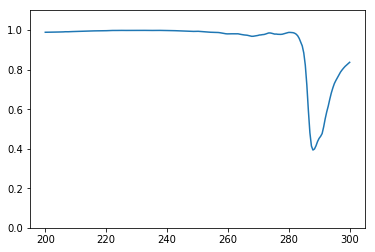

Test 17
True spectrum: 


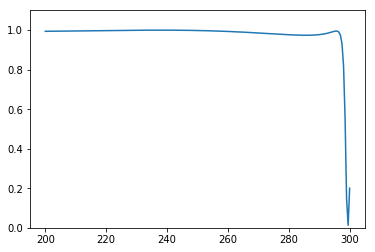

Predicted spectrum: 


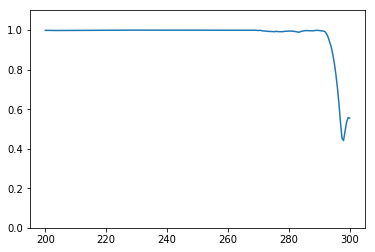

Test 18
True spectrum: 


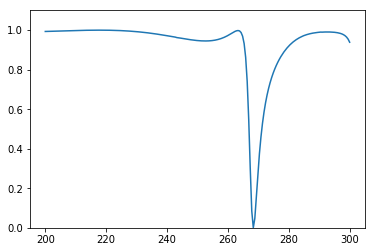

Predicted spectrum: 


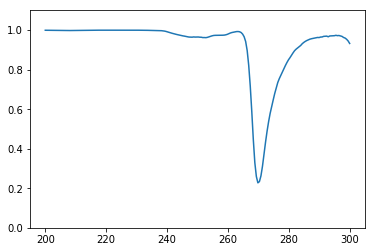

Test 19
True spectrum: 


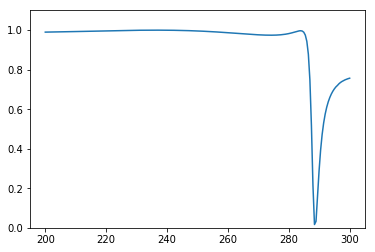

Predicted spectrum: 


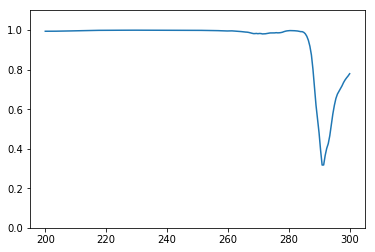

Test 20
True spectrum: 


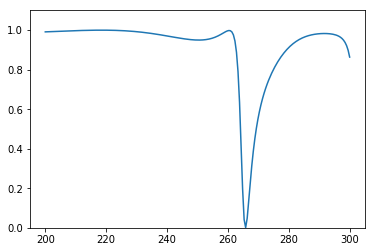

Predicted spectrum: 


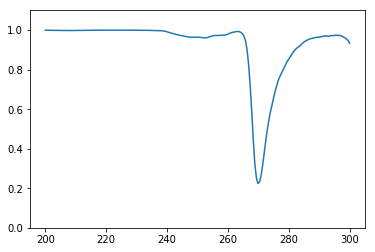

Test 21
True spectrum: 


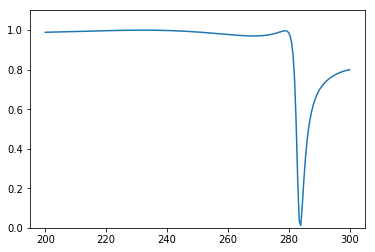

Predicted spectrum: 


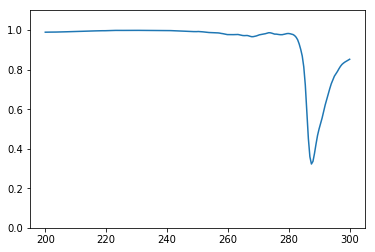

Test 22
True spectrum: 


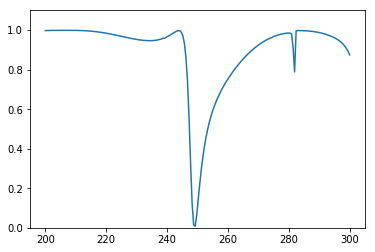

Predicted spectrum: 


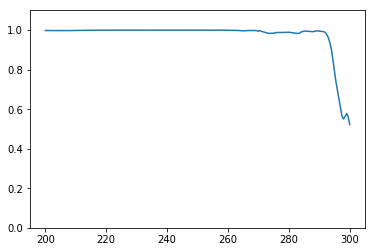

Test 23
True spectrum: 


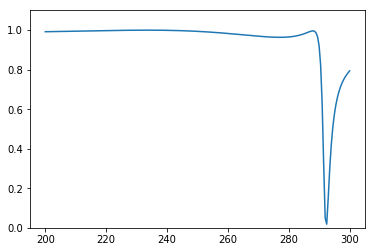

Predicted spectrum: 


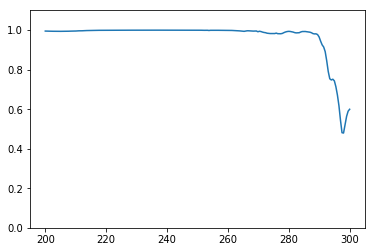

Test 24
True spectrum: 


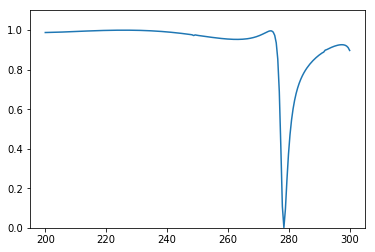

Predicted spectrum: 


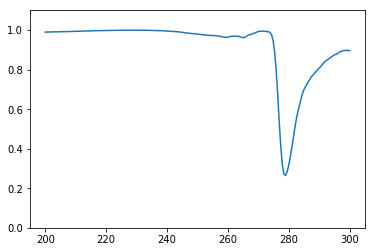

Test 25
True spectrum: 


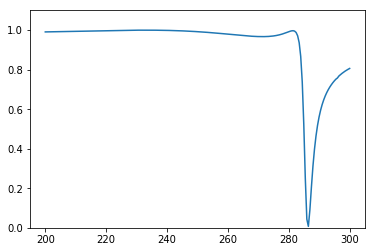

Predicted spectrum: 


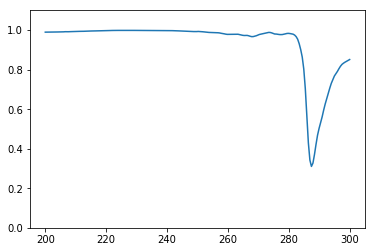

Test 26
True spectrum: 


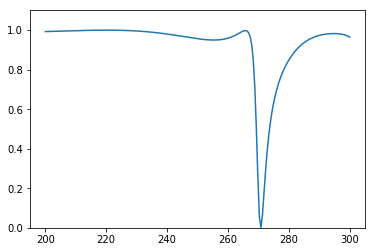

Predicted spectrum: 


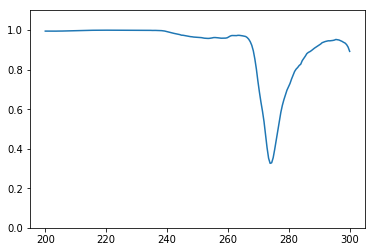

Test 27
True spectrum: 


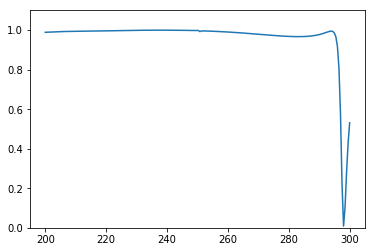

Predicted spectrum: 


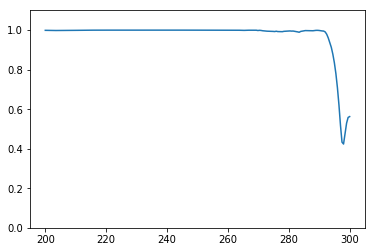

Test 28
True spectrum: 


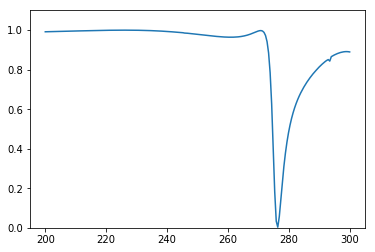

Predicted spectrum: 


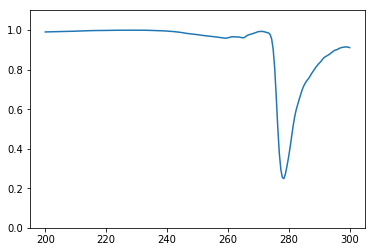

Test 29
True spectrum: 


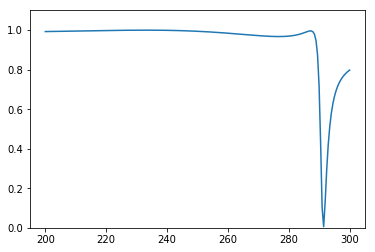

Predicted spectrum: 


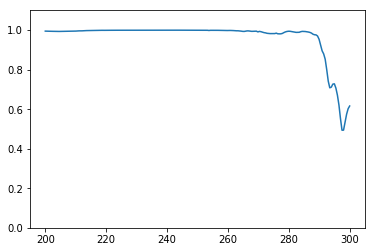

Test 30
True spectrum: 


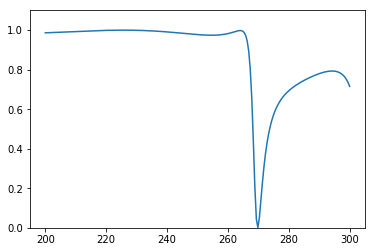

Predicted spectrum: 


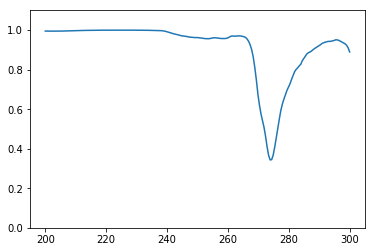

Test 31
True spectrum: 


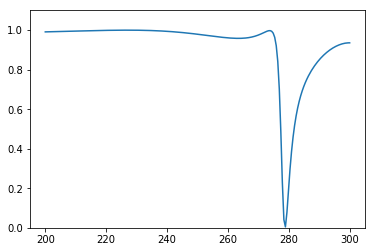

Predicted spectrum: 


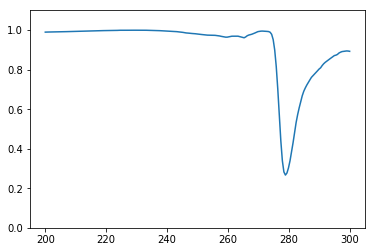

Test 32
True spectrum: 


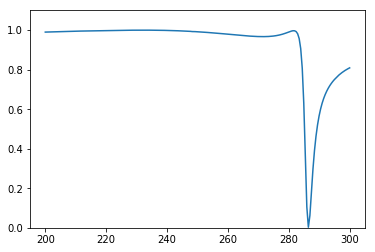

Predicted spectrum: 


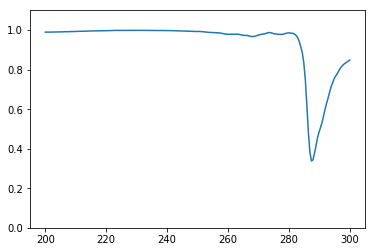

Test 33
True spectrum: 


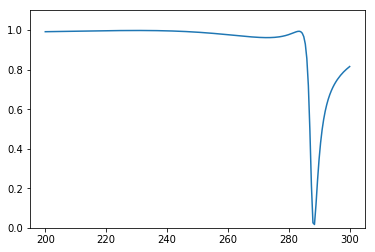

Predicted spectrum: 


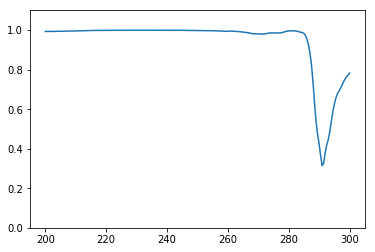

Test 34
True spectrum: 


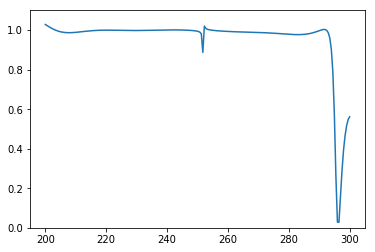

Predicted spectrum: 


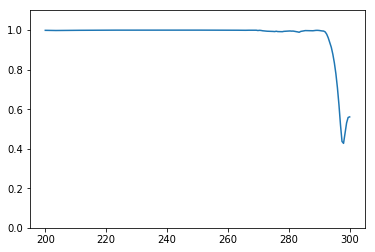

Test 35
True spectrum: 


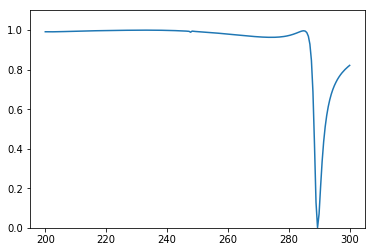

Predicted spectrum: 


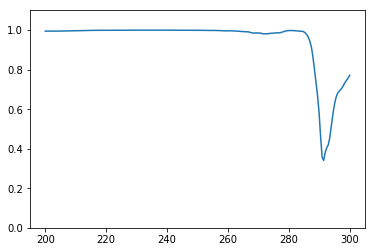

Test 36
True spectrum: 


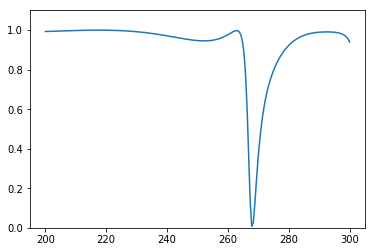

Predicted spectrum: 


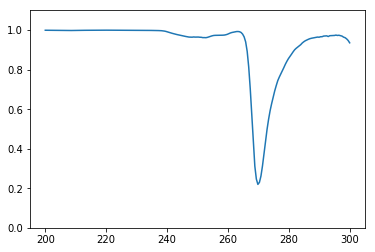

Test 37
True spectrum: 


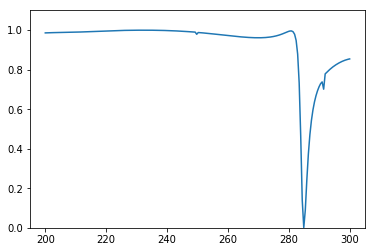

Predicted spectrum: 


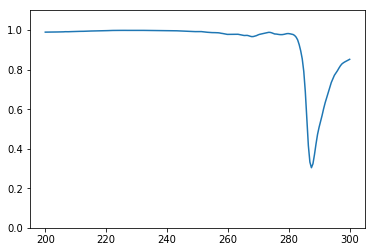

Test 38
True spectrum: 


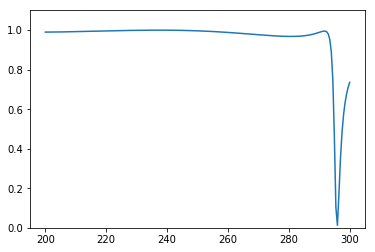

Predicted spectrum: 


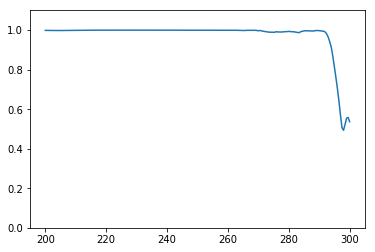

Test 39
True spectrum: 


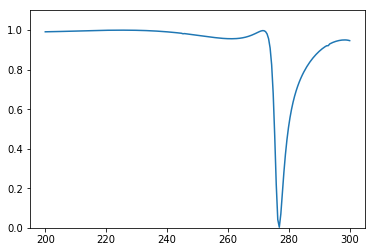

Predicted spectrum: 


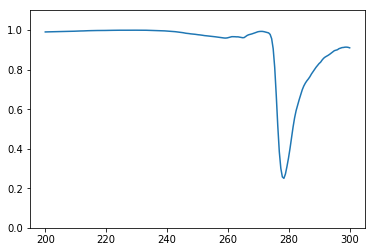

Test 40
True spectrum: 


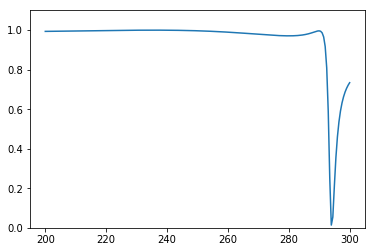

Predicted spectrum: 


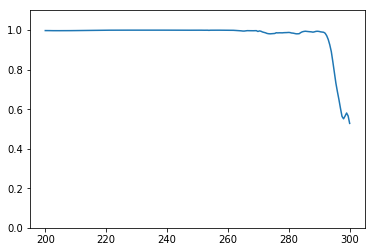

Test 41
True spectrum: 


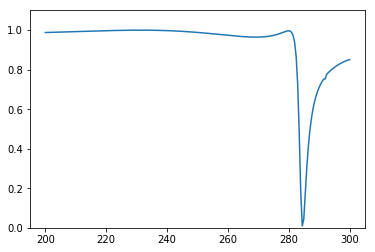

Predicted spectrum: 


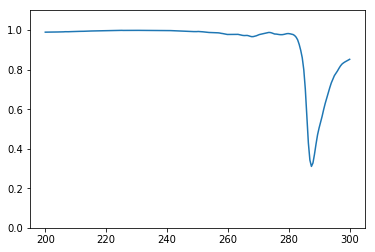

Test 42
True spectrum: 


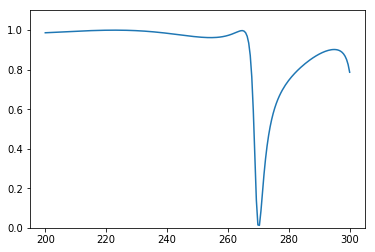

Predicted spectrum: 


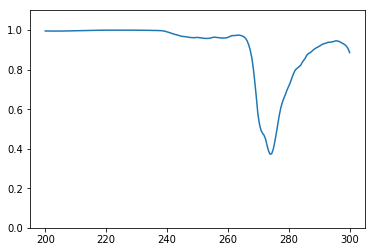

Test 43
True spectrum: 


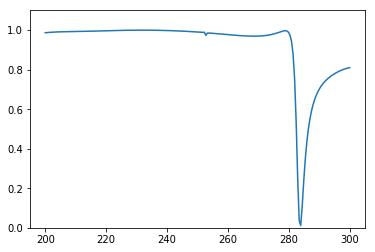

Predicted spectrum: 


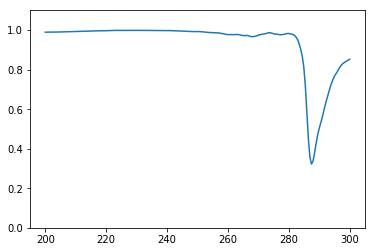

Test 44
True spectrum: 


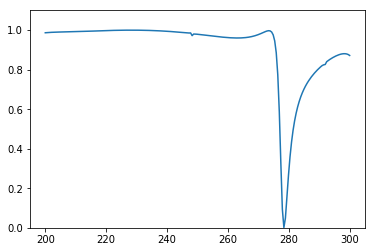

Predicted spectrum: 


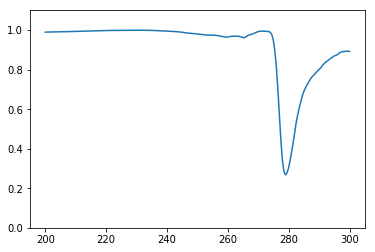

Test 45
True spectrum: 


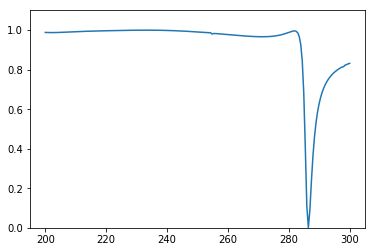

Predicted spectrum: 


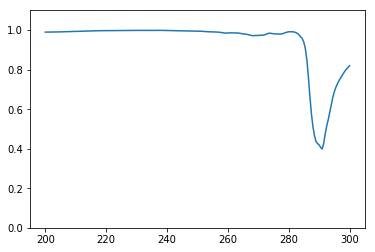

Test 46
True spectrum: 


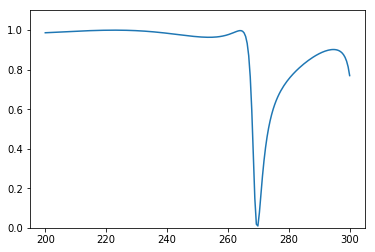

Predicted spectrum: 


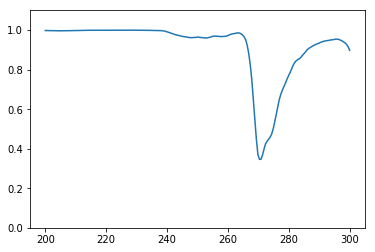

Test 47
True spectrum: 


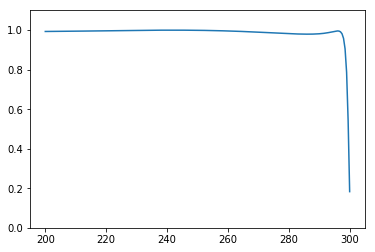

Predicted spectrum: 


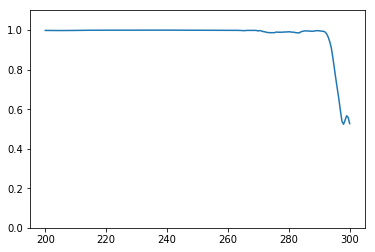

Test 48
True spectrum: 


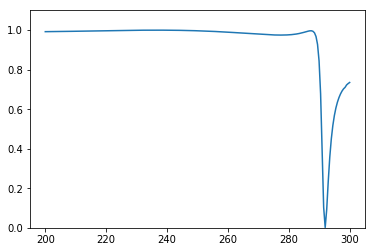

Predicted spectrum: 


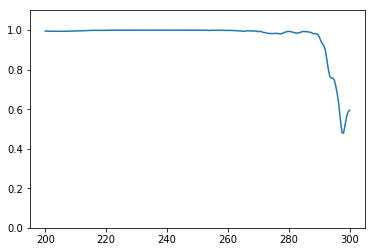

Test 49
True spectrum: 


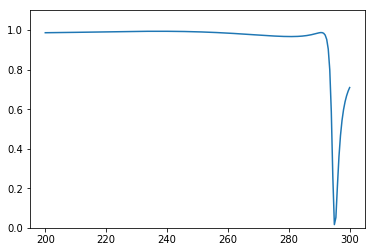

Predicted spectrum: 


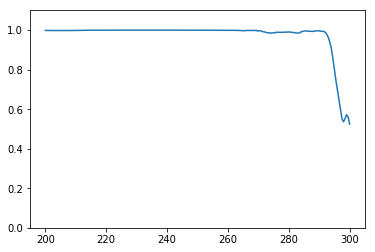

Test 50
True spectrum: 


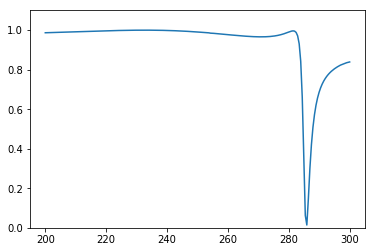

Predicted spectrum: 


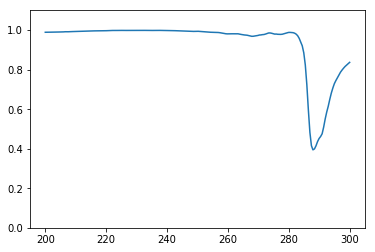

Test 51
True spectrum: 


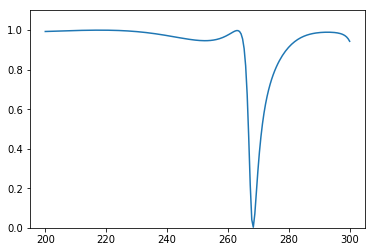

Predicted spectrum: 


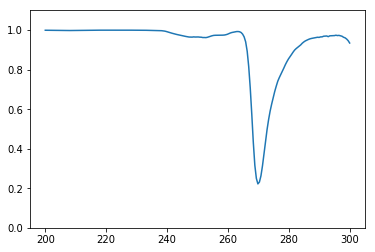

Test 52
True spectrum: 


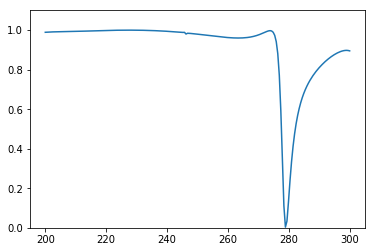

Predicted spectrum: 


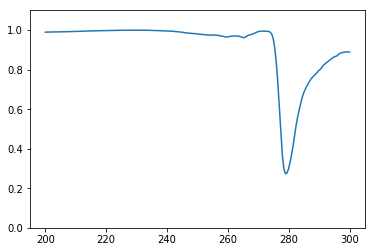

Test 53
True spectrum: 


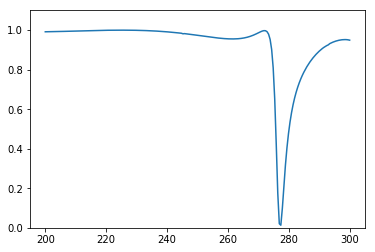

Predicted spectrum: 


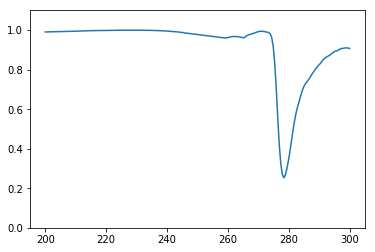

Test 54
True spectrum: 


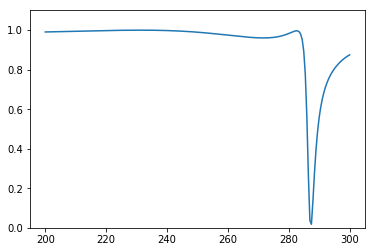

Predicted spectrum: 


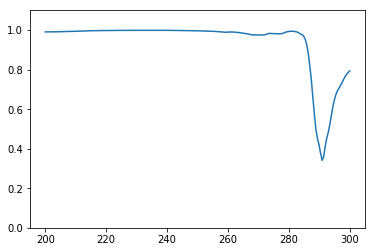

Test 55
True spectrum: 


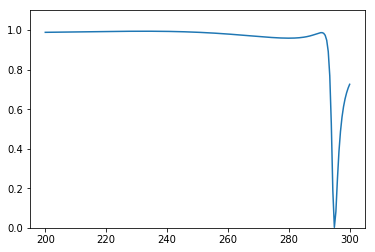

Predicted spectrum: 


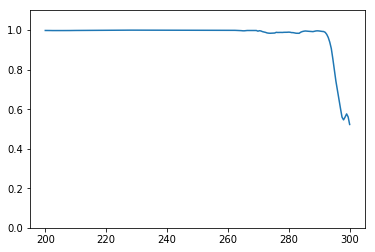

Test 56
True spectrum: 


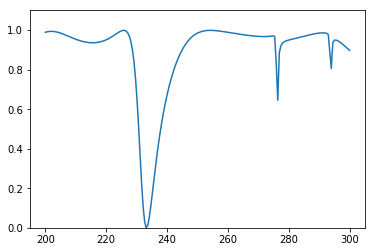

Predicted spectrum: 


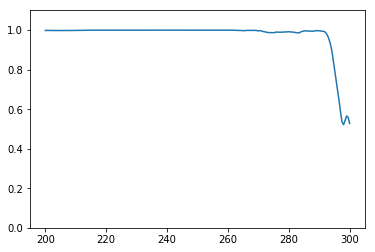

Test 57
True spectrum: 


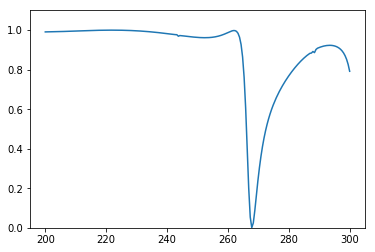

Predicted spectrum: 


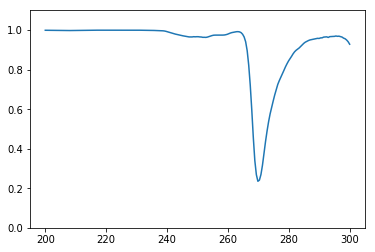

Test 58
True spectrum: 


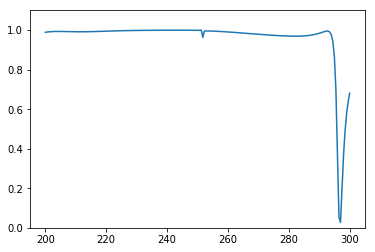

Predicted spectrum: 


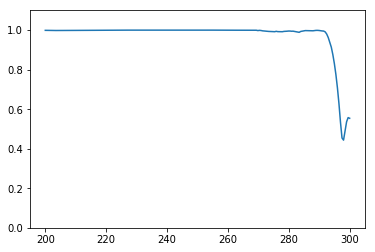

Test 59
True spectrum: 


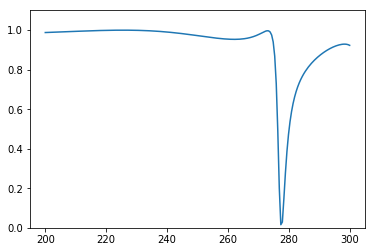

Predicted spectrum: 


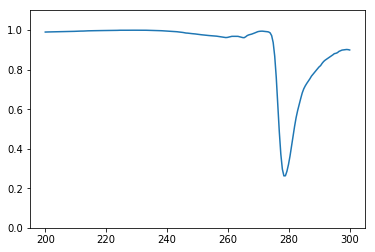

Test 60
True spectrum: 


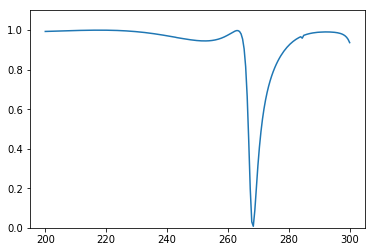

Predicted spectrum: 


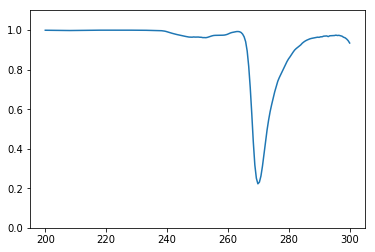

Test 61
True spectrum: 


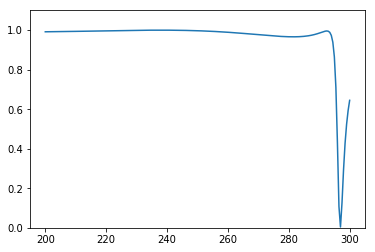

Predicted spectrum: 


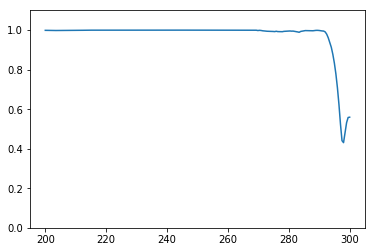

Test 62
True spectrum: 


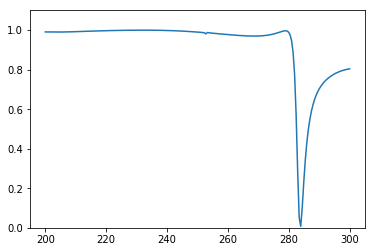

Predicted spectrum: 


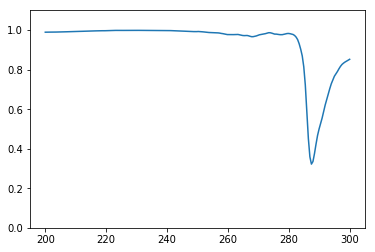

Test 63
True spectrum: 


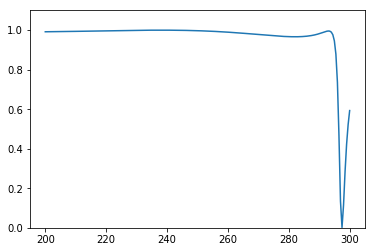

Predicted spectrum: 


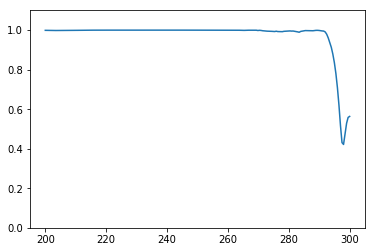

Test 64
True spectrum: 


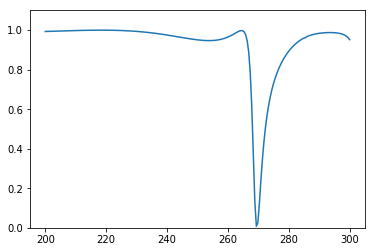

Predicted spectrum: 


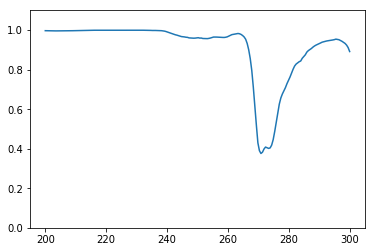

Test 65
True spectrum: 


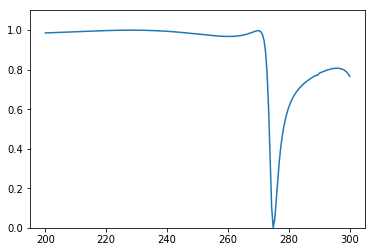

Predicted spectrum: 


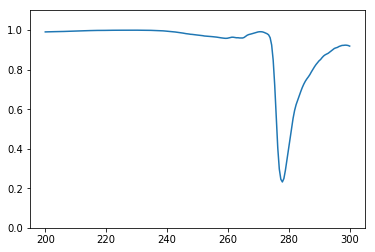

Test 66
True spectrum: 


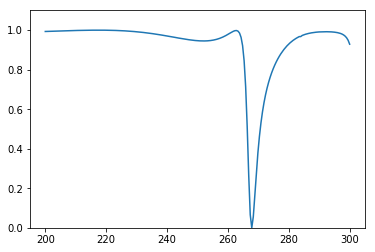

Predicted spectrum: 


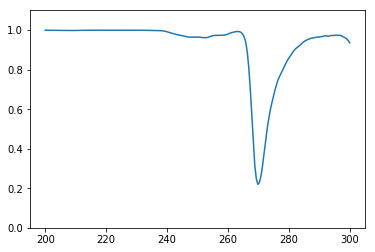

Test 67
True spectrum: 


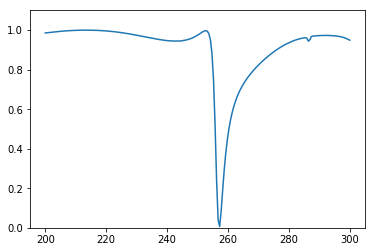

Predicted spectrum: 


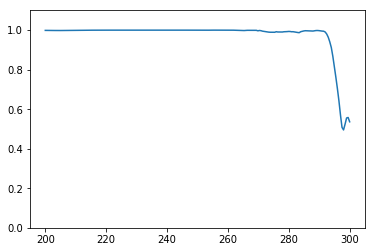

Test 68
True spectrum: 


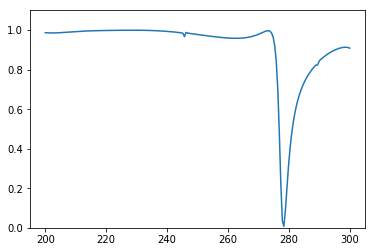

Predicted spectrum: 


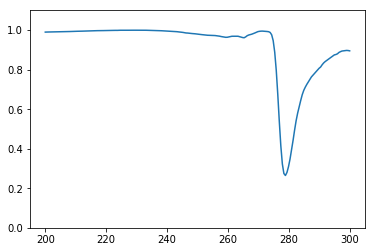

Test 69
True spectrum: 


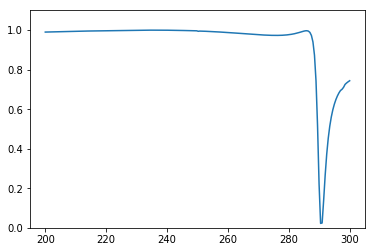

Predicted spectrum: 


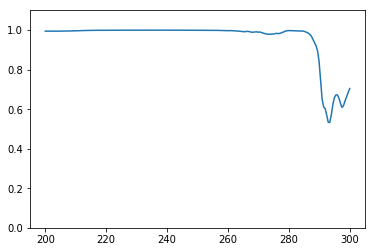

Test 70
True spectrum: 


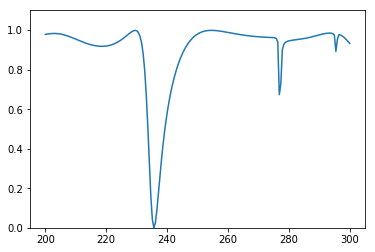

Predicted spectrum: 


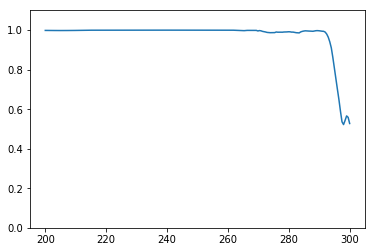

Test 71
True spectrum: 


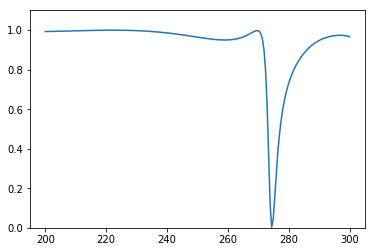

Predicted spectrum: 


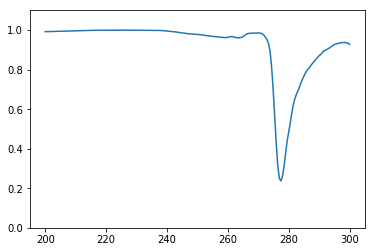

Test 72
True spectrum: 


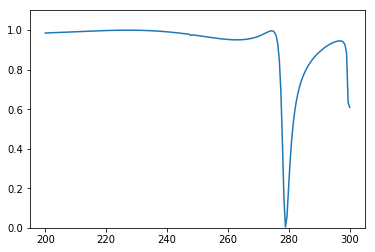

Predicted spectrum: 


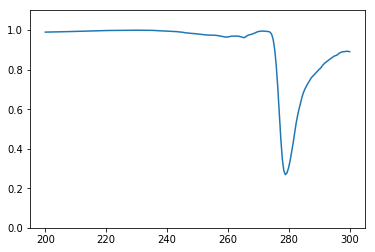

Test 73
True spectrum: 


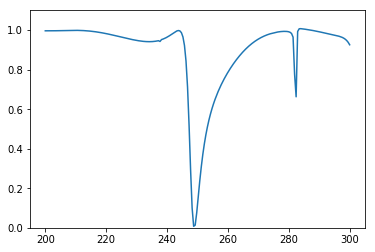

Predicted spectrum: 


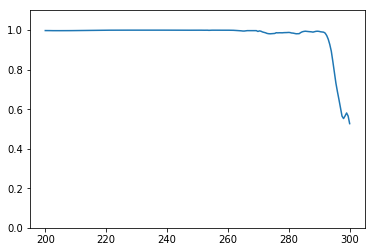

Test 74
True spectrum: 


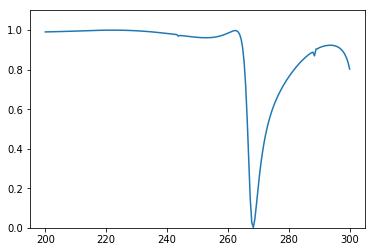

Predicted spectrum: 


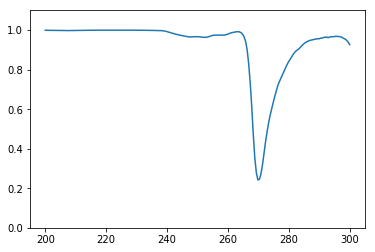

Test 75
True spectrum: 


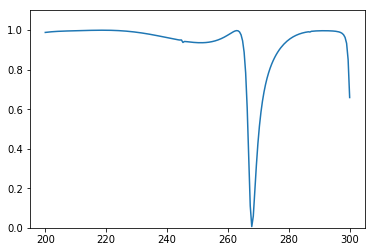

Predicted spectrum: 


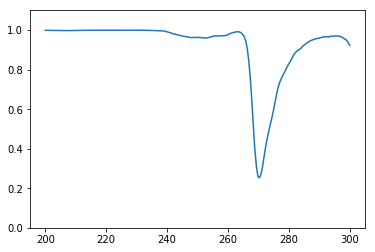

Test 76
True spectrum: 


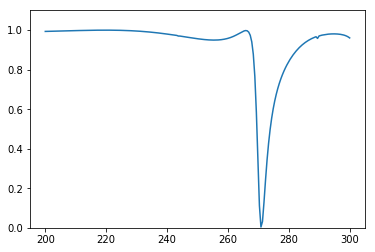

Predicted spectrum: 


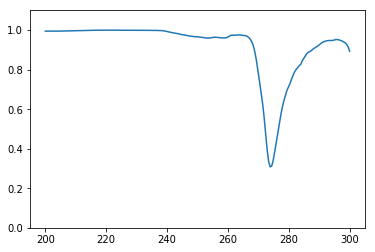

Test 77
True spectrum: 


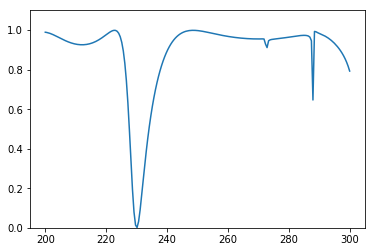

Predicted spectrum: 


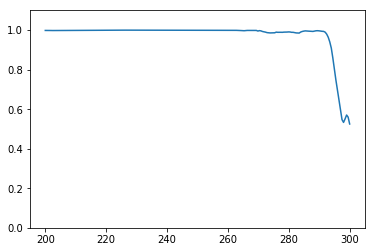

Test 78
True spectrum: 


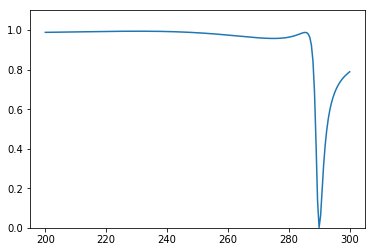

Predicted spectrum: 


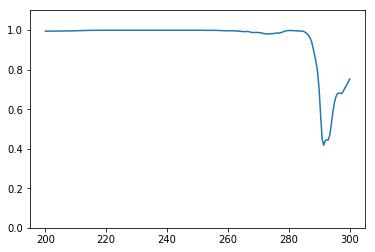

Test 79
True spectrum: 


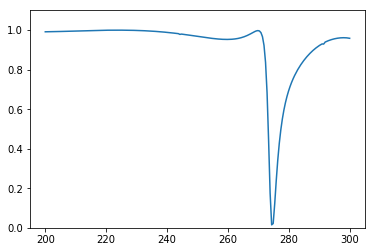

Predicted spectrum: 


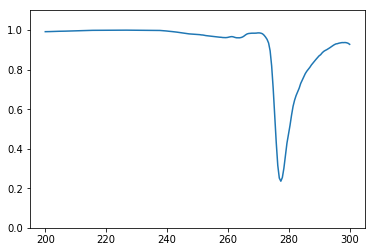

Test 80
True spectrum: 


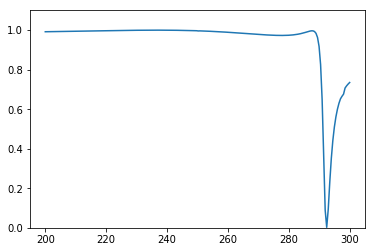

Predicted spectrum: 


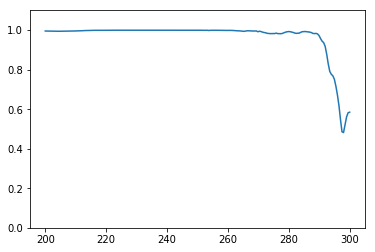

Test 81
True spectrum: 


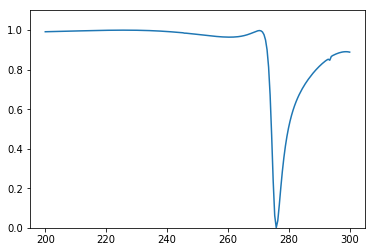

Predicted spectrum: 


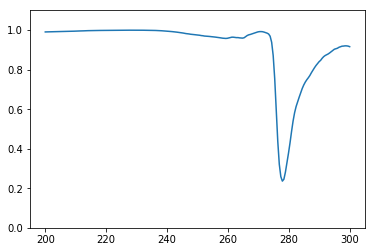

Test 82
True spectrum: 


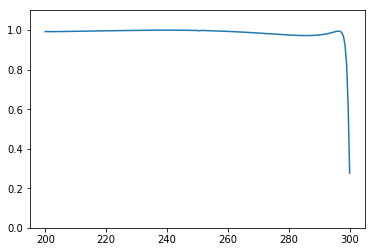

Predicted spectrum: 


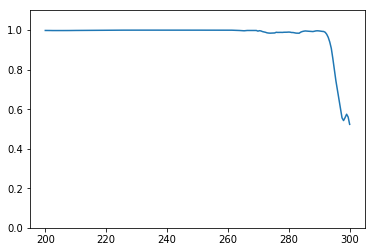

Test 83
True spectrum: 


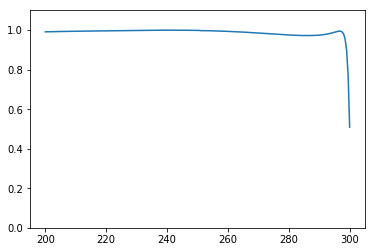

Predicted spectrum: 


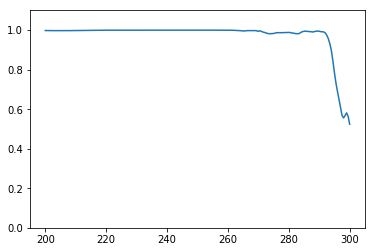

Test 84
True spectrum: 


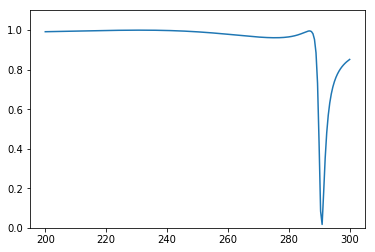

Predicted spectrum: 


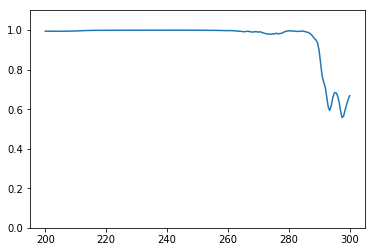

Test 85
True spectrum: 


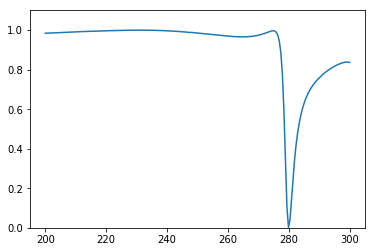

Predicted spectrum: 


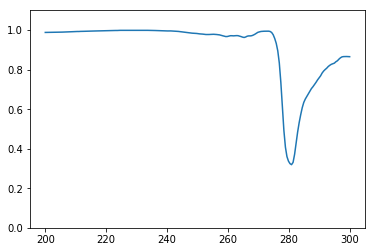

Test 86
True spectrum: 


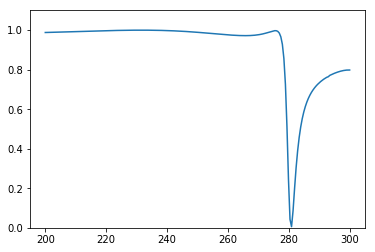

Predicted spectrum: 


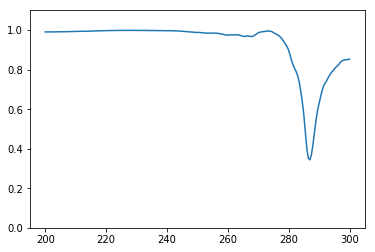

Test 87
True spectrum: 


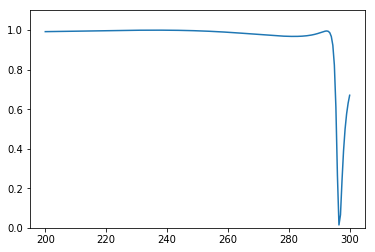

Predicted spectrum: 


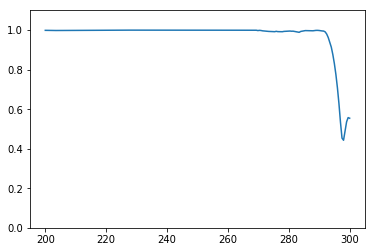

Test 88
True spectrum: 


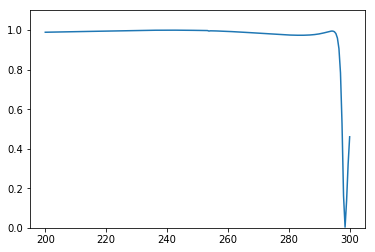

Predicted spectrum: 


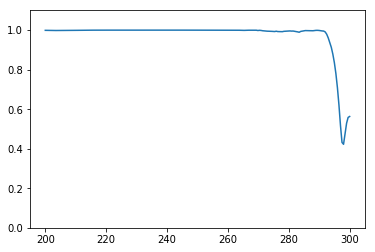

Test 89
True spectrum: 


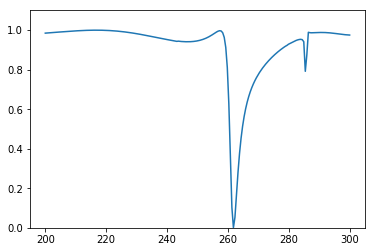

Predicted spectrum: 


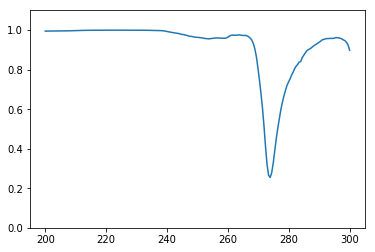

Test 90
True spectrum: 


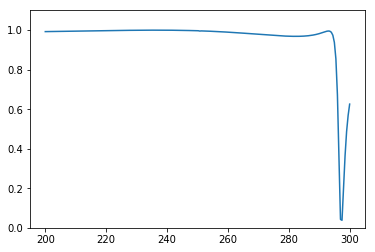

Predicted spectrum: 


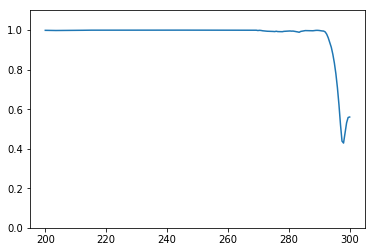

Test 91
True spectrum: 


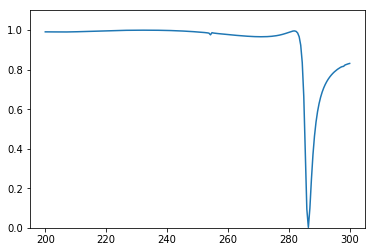

Predicted spectrum: 


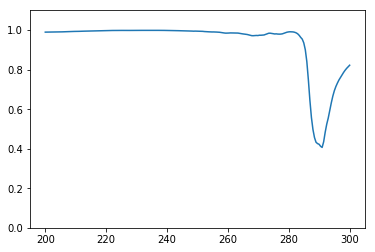

Test 92
True spectrum: 


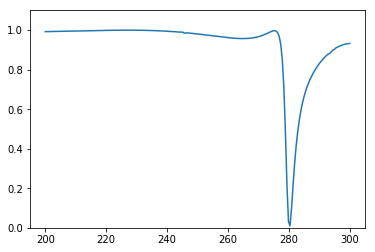

Predicted spectrum: 


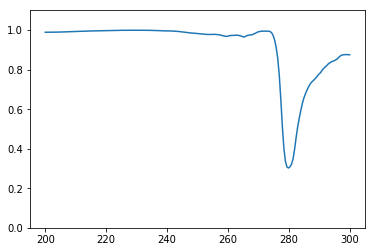

In [83]:
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(len(test_Y)):
    print('Test '+str(i))
    print('True spectrum: ')
    plt.ylim(0, 1.1)
    plt.plot(x, test_Y[i])
    plt.show()
    print('Predicted spectrum: ')
    plt.ylim(0, 1.1)
    plt.plot(x, np.reshape(tandem.predict(np.reshape(test_Y[i], (1, 200))), (200,)))
    plt.show()

In [84]:
inverse = Sequential()
for layer in tandem.layers[:5]:
    layer.trainable=False
    inverse.add(layer)

In [85]:
inverse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 500)               100500    
_________________________________________________________________
dropout_28 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               100200    
_________________________________________________________________
dropout_29 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 1206      
Total params: 201,906
Trainable params: 0
Non-trainable params: 201,906
_________________________________________________________________


Test 0
True spectrum: 


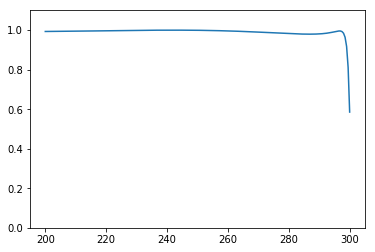

True shape
[0.2        0.19753767 0.2        0.1        0.1        0.2       ]
Predicted shape: 
[[2.8745314e-01 7.3999166e-05 1.5368444e-01 2.1050829e-01 2.6182210e-04
  2.7586827e-01]]
[[0.02954882 0.03758782 0.03840134 0.04030824 0.07921601 0.05690476]]
Test 1
True spectrum: 


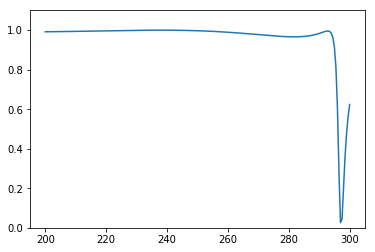

True shape
[0.2        0.2        0.13169178 0.1        0.2        0.19753767]
Predicted shape: 
[[2.50534594e-01 1.61826611e-05 1.02423936e-01 1.42590612e-01
  9.44011117e-05 3.20634723e-01]]
[[0.02927634 0.03759047 0.05224404 0.04793733 0.04742324 0.04414028]]
Test 2
True spectrum: 


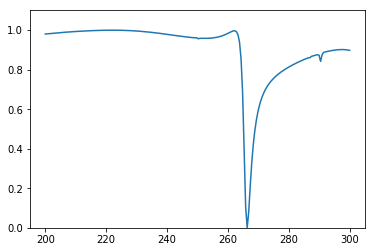

True shape
[0.4 0.3 0.2 0.1 0.1 0.1]
Predicted shape: 
[[0.37827197 0.00795978 0.16773978 0.35608637 0.09488433 0.361563  ]]
[[0.04603335 0.03661072 0.04469925 0.0498867  0.11737521 0.11239524]]
Test 3
True spectrum: 


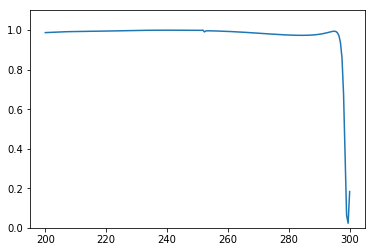

True shape
[0.3        0.2        0.1        0.11723925 0.14600443 0.2       ]
Predicted shape: 
[[2.4947518e-01 1.5169382e-05 1.0130468e-01 1.4144665e-01 9.0117734e-05
  3.2151532e-01]]
[[0.0871129  0.1331124  0.13555968 0.11594474 0.13190618 0.14004123]]
Test 4
True spectrum: 


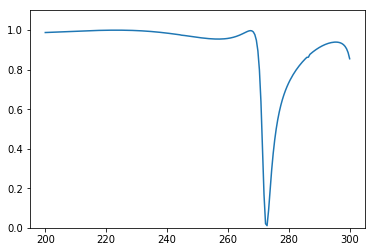

True shape
[0.2       0.2       0.1       0.2       0.2370452 0.3      ]
Predicted shape: 
[[0.36908332 0.00558537 0.21484578 0.3663696  0.05184031 0.31859097]]
[[0.05536082 0.06050169 0.07457435 0.05615798 0.0854567  0.08628736]]
Test 5
True spectrum: 


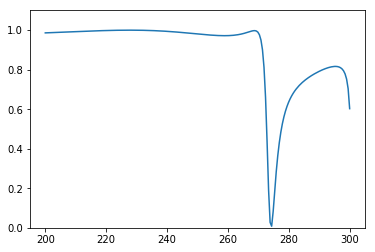

True shape
[0.2963065  0.3        0.2        0.1        0.09876883 0.1       ]
Predicted shape: 
[[0.37590918 0.00529265 0.21269512 0.36490297 0.03515903 0.3135108 ]]
[[0.09673896 0.10011882 0.12429395 0.1008943  0.10787818 0.11623503]]
Test 6
True spectrum: 


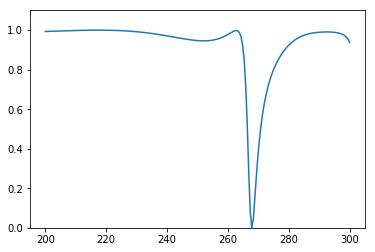

True shape
[0.19753767 0.2        0.2        0.2        0.2        0.19753767]
Predicted shape: 
[[0.3795982  0.00649232 0.15881267 0.35672063 0.09610694 0.37173143]]
[[0.04491758 0.03811893 0.04269442 0.05055785 0.11087134 0.13347131]]
Test 7
True spectrum: 


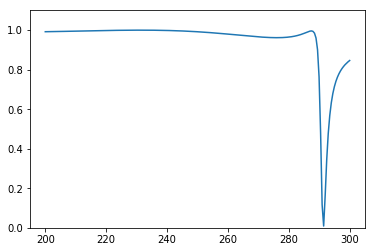

True shape
[0.2        0.19753767 0.2        0.2        0.1        0.09876883]
Predicted shape: 
[[3.2657641e-01 1.4182925e-04 2.0602518e-01 2.7591467e-01 3.1187548e-04
  2.3628210e-01]]
[[0.10006851 0.06229585 0.08330336 0.07423776 0.12285794 0.07073813]]
Test 8
True spectrum: 


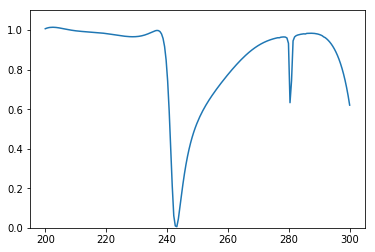

True shape
[0.4 0.3 0.3 0.2 0.1 0.1]
Predicted shape: 
[[2.53424495e-01 1.83582306e-05 1.04971826e-01 1.45387560e-01
  1.07334621e-04 3.19330364e-01]]
[[0.4155151  0.2623055  0.1993263  0.10670602 0.12576151 0.2068472 ]]
Test 9
True spectrum: 


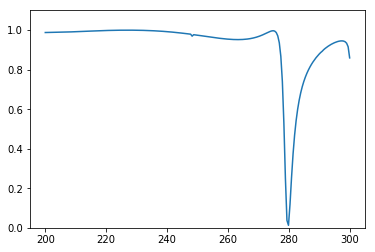

True shape
[0.3       0.2370452 0.2       0.1       0.2       0.1      ]
Predicted shape: 
[[0.40176407 0.00476363 0.20713481 0.35836247 0.01166476 0.28809986]]
[[0.05888614 0.05672547 0.07338259 0.06258366 0.07662364 0.04893804]]


In [92]:
predicted = []
dfnn_o = load_model('DFNN_O')
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(10):
    print('Test '+str(i))
    print('True spectrum: ')
    plt.ylim(0, 1.1)
    plt.plot(x, test_Y[i])
    plt.show()
    print('True shape')
    print(test_X[i])
    print('Predicted shape: ')
#     predicted.append(test_Y[i])
#     predicted.append(test_X[i])
    print(inverse.predict(np.reshape(test_Y[i], (1, 200))))
    predicted.append(*inverse.predict(np.reshape(test_Y[i], (1, 200))))
    print(dfnn_o.predict(np.reshape(test_Y[i], (1, 200))))
    predicted.append(*dfnn_o.predict(np.reshape(test_Y[i], (1, 200))))

In [58]:
simulator.save('T_S')
tandem.save('T_T')
inverse.save('T_I')

In [91]:
predicted

[array([0.99318643, 0.99325307, 0.99332109, 0.9933903 , 0.9934606 ,
        0.99353188, 0.99360412, 0.99367728, 0.9937514 , 0.99382648,
        0.99390258, 0.99397974, 0.99405802, 0.99413748, 0.99421818,
        0.99430016, 0.99438347, 0.99446816, 0.99455426, 0.99464179,
        0.99473076, 0.99482119, 0.99491305, 0.99500635, 0.99510105,
        0.99519712, 0.99529452, 0.99539319, 0.99549308, 0.99559412,
        0.99569624, 0.99579936, 0.99590339, 0.99600824, 0.99611383,
        0.99622005, 0.9963268 , 0.99643398, 0.99654149, 0.99664921,
        0.99675703, 0.99686485, 0.99697255, 0.99708002, 0.99718714,
        0.9972938 , 0.99739989, 0.99750529, 0.99760988, 0.99771356,
        0.9978162 , 0.9979177 , 0.99801793, 0.99811679, 0.99821415,
        0.99830992, 0.99840396, 0.99849617, 0.99858644, 0.99867466,
        0.9987607 , 0.99884445, 0.99892581, 0.99900467, 0.99908089,
        0.99915439, 0.99922503, 0.99929271, 0.99935732, 0.99941873,
        0.99947685, 0.99953155, 0.99958272, 0.99

In [93]:
np.savetxt('prediction.txt', predicted)